In [1]:
!pip install pysindy

In [2]:
!pip install cvxpy

In [2]:
# Libraries import

import sys
import io
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pysindy as ps
from pysindy.optimizers import STLSQ
from pysindy import SINDy
import math

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Optimizer libraries

from pysindy.optimizers import SR3              #optimizer = SR3(threshold=0.1, nu=1e-2)
from sklearn.linear_model import Lasso          #optimizer = Lasso(alpha=0.1)
from sklearn.linear_model import ElasticNet     #optimizer = ElasticNet(alpha=0.1, l1_ratio=0.5)
from pysindy.optimizers import FROLS            #optimizer = FROLS()
from pysindy.optimizers import STLSQ            #optimizer = STLSQ(threshold=0.01, alpha=1e-5)  alpha is the L2 regularization parameter
from pysindy.optimizers import ConstrainedSR3
#from pysindy.optimizers import MIOSR
from pysindy.optimizers import SR3
from pysindy.optimizers import sindy_pi
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import Akima1DInterpolator
from scipy.ndimage import gaussian_filter, gaussian_filter1d

**Load the data below by running the cell for UNNORMALIZED RESULTS**

In [3]:
# Load the parameters data
params_df = pd.read_csv('Parameters/channel_parameters.csv')

# Load the couette parameters data
couette_params_df = pd.read_csv('Parameters/couette_parameters.csv')

# Load channel Augmented results data
channel_int_augmented_datafilenames = {
    180: 'Unnormalized_interpolated_data\Channel_180_unnormalized.csv',
    550: 'Unnormalized_interpolated_data\Channel_550_unnormalized.csv',
    1000:'Unnormalized_interpolated_data\Channel_1000_unnormalized.csv',
    2000:'Unnormalized_interpolated_data\Channel_2000_unnormalized.csv',
    5200:'Unnormalized_interpolated_data\Channel_5200_unnormalized.csv'
}

# Load couette Augmented results data
couette_int_augmented_datafilenames = {
    9320:   'Unnormalized_interpolated_data\Couette_9320_unnormalized.csv',
    93100:  'Unnormalized_interpolated_data\Couette_93100_unnormalized.csv',
    22020:  'Unnormalized_interpolated_data\Couette_22020_unnormalized.csv',
    220100: 'Unnormalized_interpolated_data\Couette_220100_unnormalized.csv',
    50020:  'Unnormalized_interpolated_data\Couette_50020_unnormalized.csv',
    500100: 'Unnormalized_interpolated_data\Couette_500100_unnormalized.csv'
}

# Refined approach after meeting  
Our new approach is to either:  
1. Find equations for each covariances with features being the velocities, the velocity gradients and basic parameters such as u_tau, re_tau, nu.  
2. Find an equation for k using the same features. Then replace k in the boussinesq hypothesis by our equation to find the covariances.  
**The following sections will focus on approach 2. Find an equation for k**

# K as a function of velocities and velocity gradients (derivated by y/delta) trained on 3 channel and 2 couette with U [-1;1]  
This section discovers an equation for k by using DNS features and DNS K as a target. This makes it so the equation holds physical meaning if we are able to generalize it to most cases.

**Training**

In [4]:
# Updated code to discover k equation (Training)
differentiation_method = ps.FiniteDifference()

datasets = {
    "Channel": [5200, 1000, 180],
    "Couette": [9320, 22020, 50020]
}

# Choose the FROLS optimizer
optimizer = FROLS(alpha=0.5, max_iter=10)
# Use a high-degree polynomial feature library
feature_library = ps.PolynomialLibrary(degree=5)

# Initialize lists to hold combined training features and targets
X_train_combined = []
X_dot_train_combined = []

# Process each dataset for training
for flow_type, ids in datasets.items():
    for id in ids:
        # Determine the correct filenames and parameters based on flow type
        filename = (channel_int_augmented_datafilenames if flow_type == "Channel" else couette_int_augmented_datafilenames)[id]
        params_df_selected = params_df if flow_type == "Channel" else couette_params_df
        params = params_df_selected[params_df_selected[flow_type.lower()] == id].iloc[0]
        
        # Load data
        int_data = pd.read_csv(filename)

        # Append simulation parameters as new columns
        for param in ['Re_tau', 'nu', 'u_tau']:
            int_data[param] = params[param]

        # Compute derivatives and append simulation parameters
        t = int_data['y'].values

        U = int_data['U'].values
        dU_dy = differentiation_method(U.reshape(-1, 1), t)
        d2U_dy2 = differentiation_method(dU_dy.flatten(), t).reshape(-1, 1)
        #d3U_dy3 = differentiation_method(d2U_dy2.flatten(), t).reshape(-1, 1)
        
        W = int_data['W'].values
        dW_dy = differentiation_method(W.reshape(-1, 1), t)
        d2W_dy2 = differentiation_method(dW_dy.flatten(), t).reshape(-1, 1)
        #d3W_dy3 = differentiation_method(d2W_dy2.flatten(), t).reshape(-1, 1)

        # Subtract -1 from 'U' for Couette files
        if flow_type == "Couette":
            int_data['U'] = int_data['U'] - 1
        
        features = np.hstack((int_data[['U']].values, #U.reshape(-1, 1), 
                              dU_dy, 
                              #d2U_dy2, 
                              int_data[['W']].values, #W.reshape(-1, 1), 
                              #dW_dy, 
                              #d2W_dy2, 
                              int_data[['Re_tau', 'nu', 'u_tau']].values))
                              
        targets = int_data[['DNS_k']].values
        
        # Append features and targets to the training lists
        X_train_combined.append(features)
        X_dot_train_combined.append(targets)

# Combine all the training features and targets from different setups
X_train_combined = np.vstack(X_train_combined)
X_dot_train_combined = np.vstack(X_dot_train_combined)

#Fit the SINDy model with the combined training data
feature_names = ['U', 
                 'dU/dy', 
                 #'d2U/dy2', 
                 'W', 
                 #'dW/dy', 
                 #'d2W/dy2', 
                 'Re_tau', 'nu', 'u_tau']
model = SINDy(optimizer=optimizer, feature_library=feature_library, feature_names=feature_names)
model.fit(X_train_combined, x_dot=X_dot_train_combined)
model.print()

(U)' = 0.143 u_tau + 696018170.859 W nu^2 + -1280.611 dU/dy^2 nu^2 + 195645675.040 dU/dy nu^3 + 1.905 Re_tau^2 nu^2 + -0.122 U^4 u_tau + 9933432.810 dU/dy^2 W nu^2 + -3075207980.717 dU/dy nu^3 u_tau + -10944836168.705 W Re_tau nu^3


**Predicted Channel DNS K**

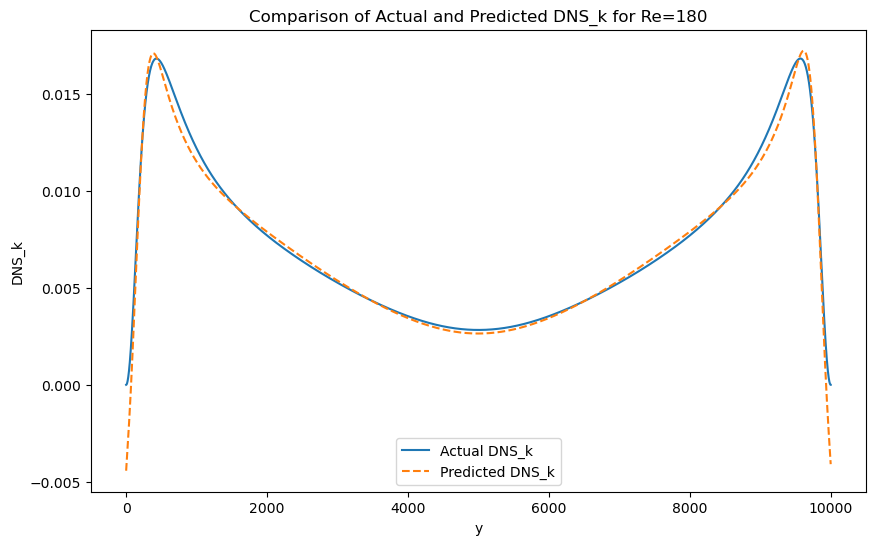

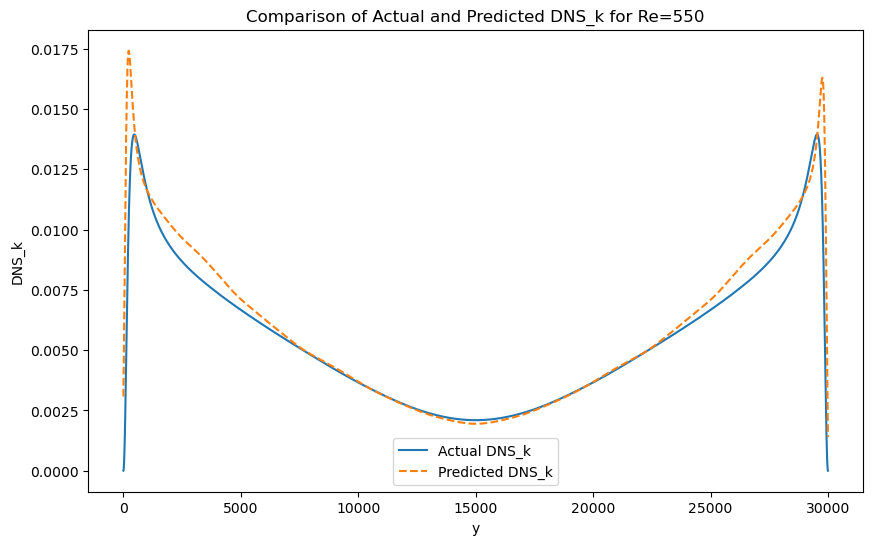

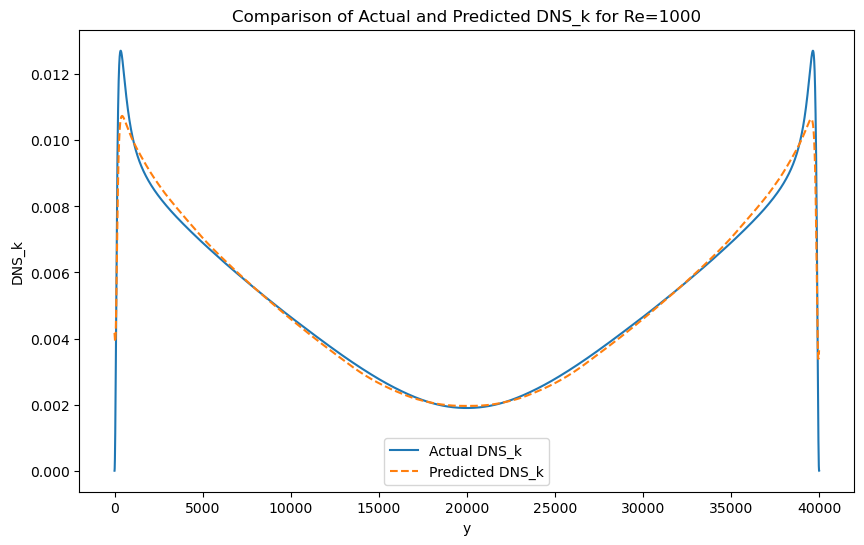

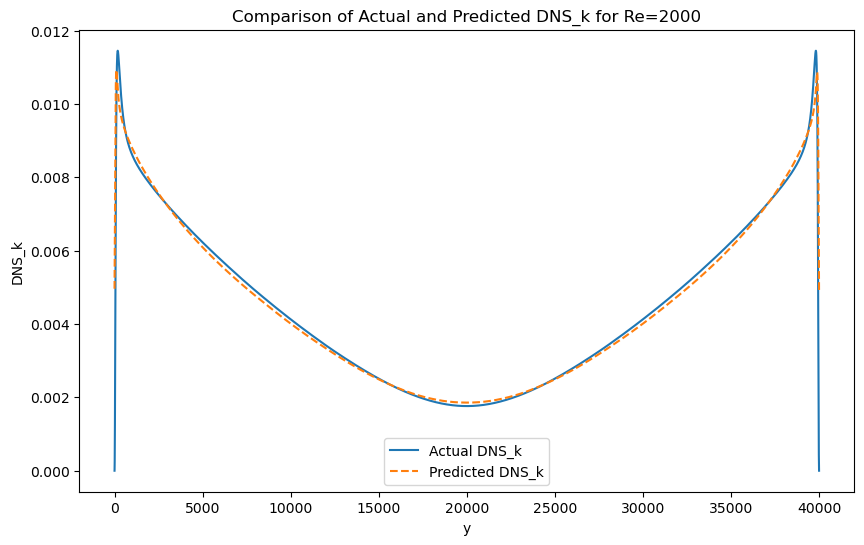

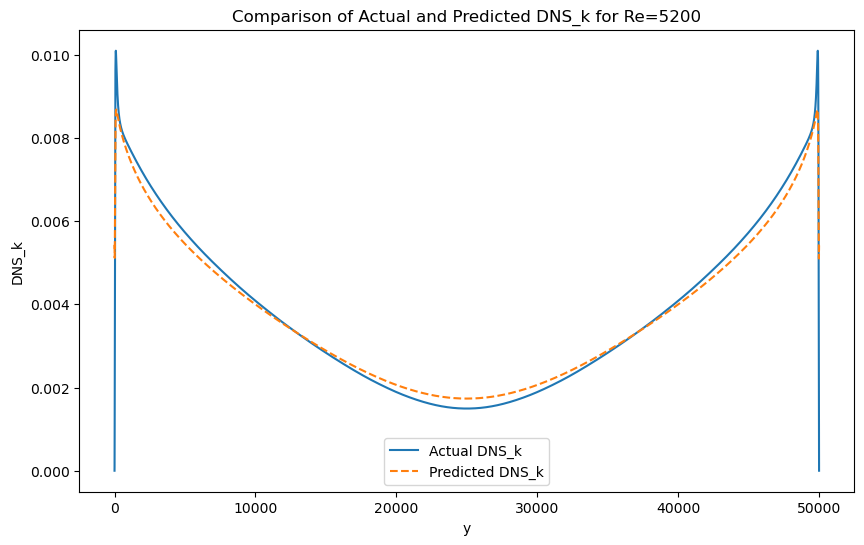

In [5]:
# Loop through all DNS data files to test the model
for channel, filename in channel_int_augmented_datafilenames.items():
    # Load the current DNS setup's data
    int_data = pd.read_csv(filename)
    params = params_df[params_df['channel'] == channel].iloc[0]
    
    # Append simulation parameters to the data for consistent feature representation
    for param in ['Re_tau', 'nu', 'u_tau']:
        int_data[param] = params[param]

    t = int_data['y'].values
    u_tau_nu = int_data['u_tau'].values / int_data['nu'].values
    tdiff = t * u_tau_nu

    # Prepare features for prediction: U, its derivatives, and simulation parameters
    U = int_data['U'].values
    dU_dy = differentiation_method(U.reshape(-1, 1), t)
    d2U_dy2 = differentiation_method(dU_dy.flatten(), t).reshape(-1, 1)
    #d3U_dy3 = differentiation_method(d2U_dy2.flatten(), t).reshape(-1, 1)
    W = int_data['W'].values
    dW_dy = differentiation_method(W.reshape(-1, 1), t)
    d2W_dy2 = differentiation_method(dW_dy.flatten(), t).reshape(-1, 1)
    #d3W_dy3 = differentiation_method(d2W_dy2.flatten(), t).reshape(-1, 1)

    features = np.hstack((int_data[['U']].values, #U.reshape(-1, 1), 
                          dU_dy, 
                          #d2U_dy2, 
                          int_data[['W']].values, #W.reshape(-1, 1), 
                          #dW_dy, 
                          #d2W_dy2, 
                          int_data[['Re_tau', 'nu', 'u_tau']].values))
    
    # Actual values
    X_dot_actual = int_data[[
        #'u\'u\'', 'v\'v\'', 'w\'w\'', 'u\'v\'', 
        'DNS_k']].values
    # Predict derivatives using the model
    X_dot_predicted = model.predict(features)
    
    # Plot actual vs. predicted derivatives
    variable_names = [
        #'u\'u\'', 'v\'v\'', 'w\'w\'', 'u\'v\'', 
        'DNS_k']
    for i, var_name in enumerate(variable_names):
        plt.figure(figsize=(10, 6))
        plt.plot(X_dot_actual[:, i], label=f'Actual {var_name}')
        plt.plot(X_dot_predicted[:, i], label=f'Predicted {var_name}', linestyle='--')
        plt.title(f'Comparison of Actual and Predicted {var_name} for Re={channel}')
        plt.xlabel('y')
        plt.ylabel(var_name)
        plt.legend()
        plt.show()

**Predicted Channel RANS K**

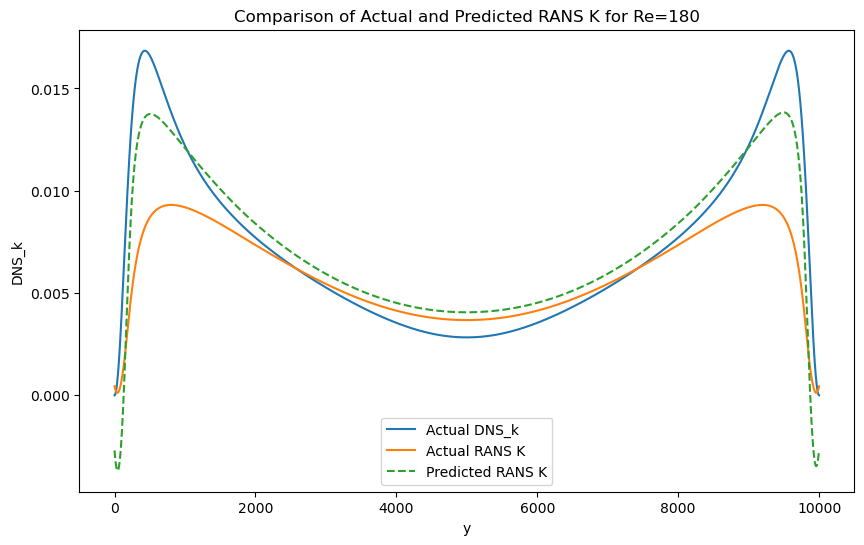

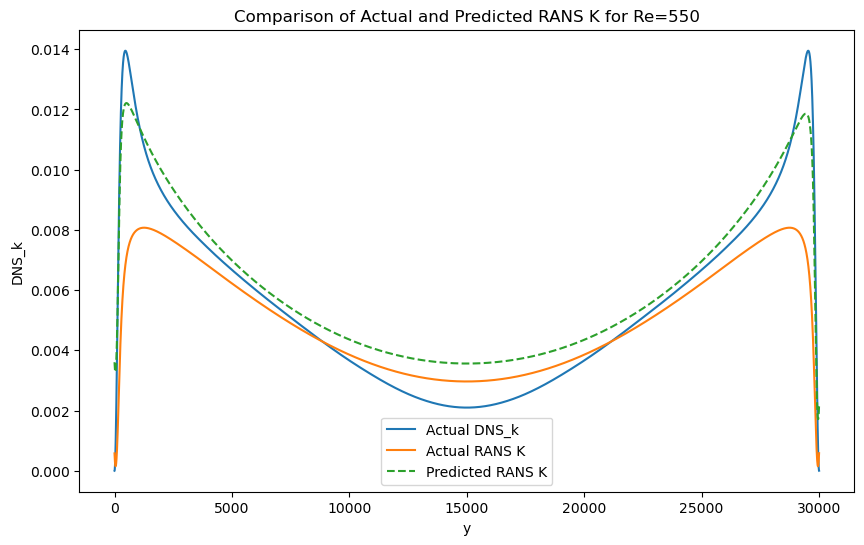

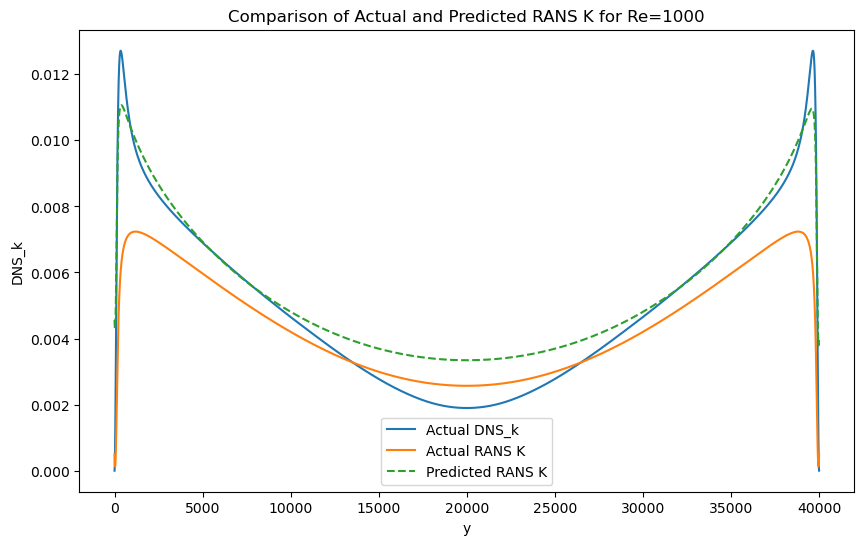

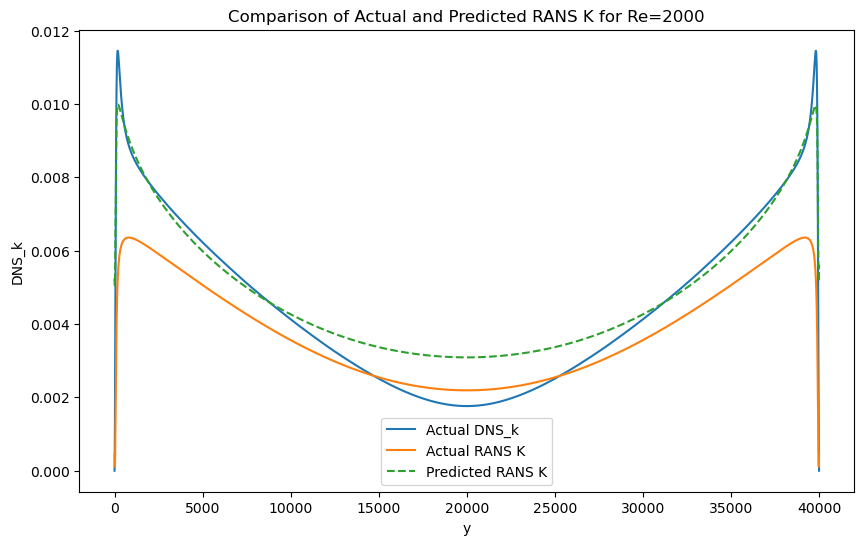

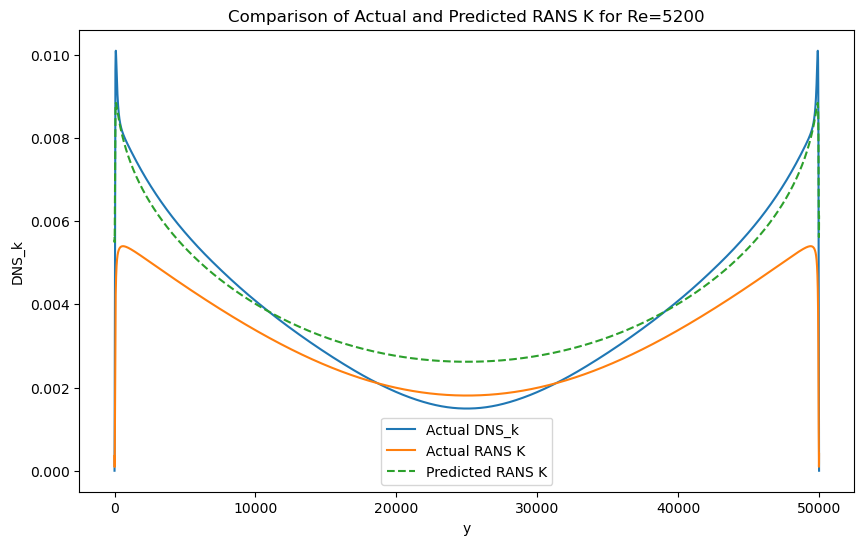

In [7]:
#----------------------------------------- GRAPHS ---------------------------------------------------------------

# Evaluate the PySINDy model's performance by comparing actual vs. predicted turbulence statistics
# across all available Reynolds numbers, including those not used in training

# Loop through all DNS data files to test the model
for channel, filename in channel_int_augmented_datafilenames.items():
    # Load the current DNS setup's data
    int_data = pd.read_csv(filename)
    params = params_df[params_df['channel'] == channel].iloc[0]
    
    # Append simulation parameters to the data for consistent feature representation
    for param in ['Re_tau', 'nu', 'u_tau']:
        int_data[param] = params[param]

    t = int_data['y'].values
    # Prepare features for prediction: U, its derivatives, and simulation parameters
    U = int_data['xvel_x'].values
    dU_dy = differentiation_method(U.reshape(-1, 1), t)
    d2U_dy2 = differentiation_method(dU_dy.flatten(), t).reshape(-1, 1)
    #d3U_dy3 = differentiation_method(d2U_dy2.flatten(), t).reshape(-1, 1)
    W = int_data['zvel_x'].values
    dW_dy = differentiation_method(W.reshape(-1, 1), t)
    d2W_dy2 = differentiation_method(dW_dy.flatten(), t).reshape(-1, 1)
    #d3W_dy3 = differentiation_method(d2W_dy2.flatten(), t).reshape(-1, 1)

    features = np.hstack((int_data[['xvel_x']].values, # U.reshape(-1, 1), 
                          dU_dy, 
                          #d2U_dy2, 
                          int_data[['zvel_x']].values, # W.reshape(-1, 1), 
                          #dW_dy, 
                          #d2W_dy2, 
                          int_data[['Re_tau', 'nu', 'u_tau']].values))
    
    # Actual values
    X_dot_actual_DNS = int_data[[
        #'u\'u\'', 'v\'v\'', 'w\'w\'', 'u\'v\'', 
        'DNS_k']].values
    
    # Actual values
    X_dot_actual_RANS = int_data[[
        #'u\'u\'', 'v\'v\'', 'w\'w\'', 'u\'v\'', 
        'RANS_k']].values
    # Predict derivatives using the model
    X_dot_predicted = model.predict(features)
    
    # Plot actual vs. predicted derivatives
    variable_names = [
        #'u\'u\'', 'v\'v\'', 'w\'w\'', 'u\'v\'', 
        'DNS_k']
    for i, var_name in enumerate(variable_names):
        plt.figure(figsize=(10, 6))
        plt.plot(X_dot_actual_DNS[:, i], label=f'Actual {var_name}')
        plt.plot(X_dot_actual_RANS[:, i], label=f'Actual RANS K')
        plt.plot(X_dot_predicted[:, i], label=f'Predicted RANS K', linestyle='--')
        plt.title(f'Comparison of Actual and Predicted RANS K for Re={channel}')
        plt.xlabel('y')
        plt.ylabel(var_name)
        plt.legend()
        plt.show()

**Predicted Couette Rans K with static bottom plate reference**

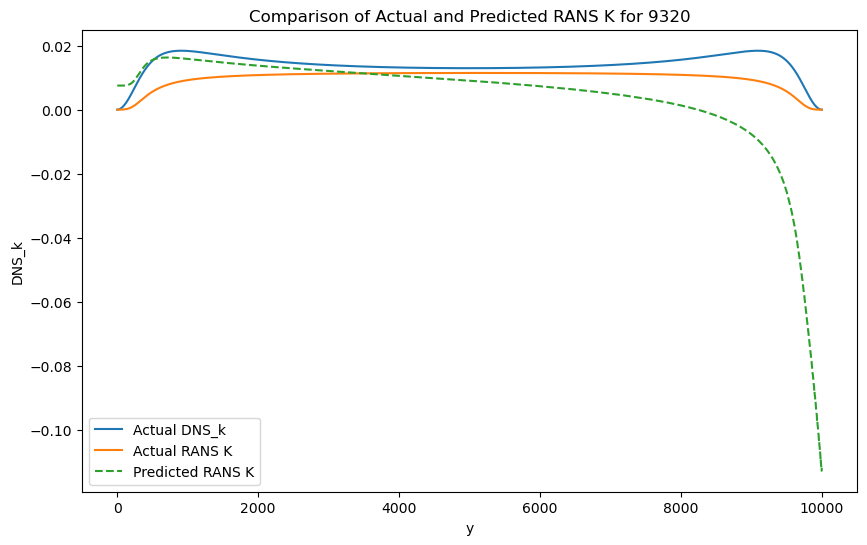

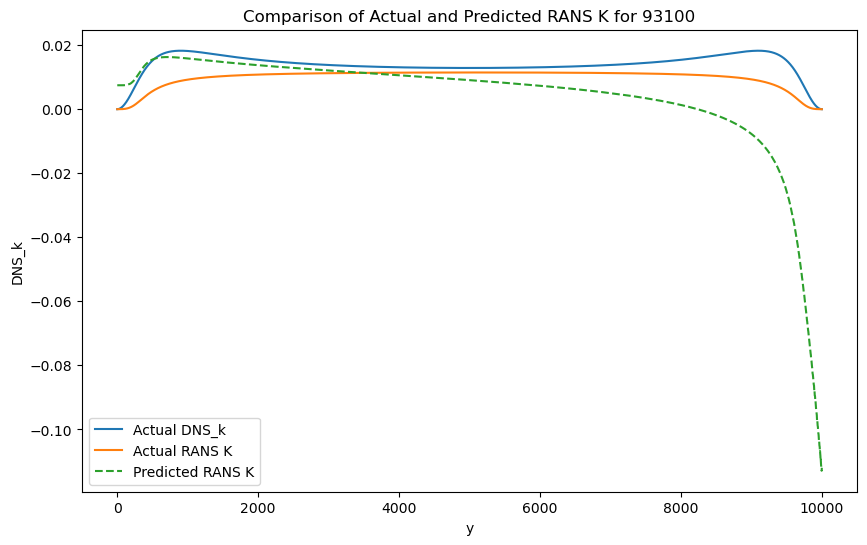

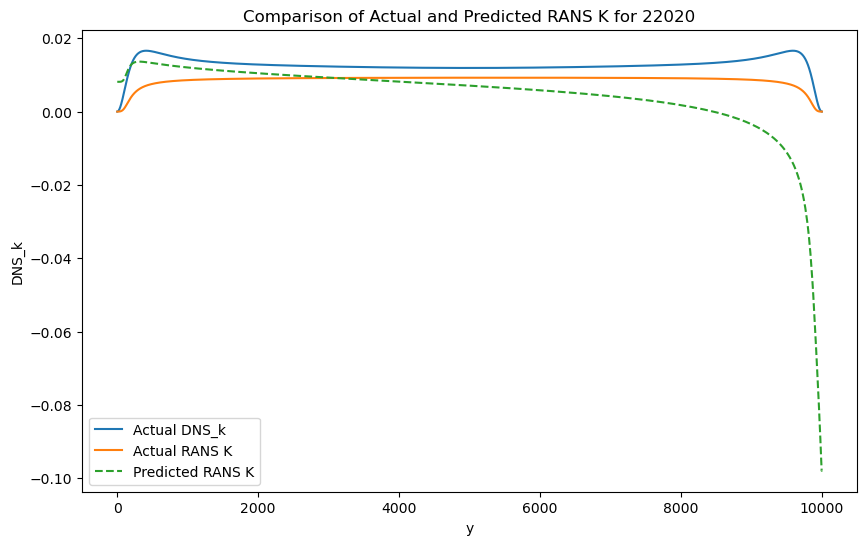

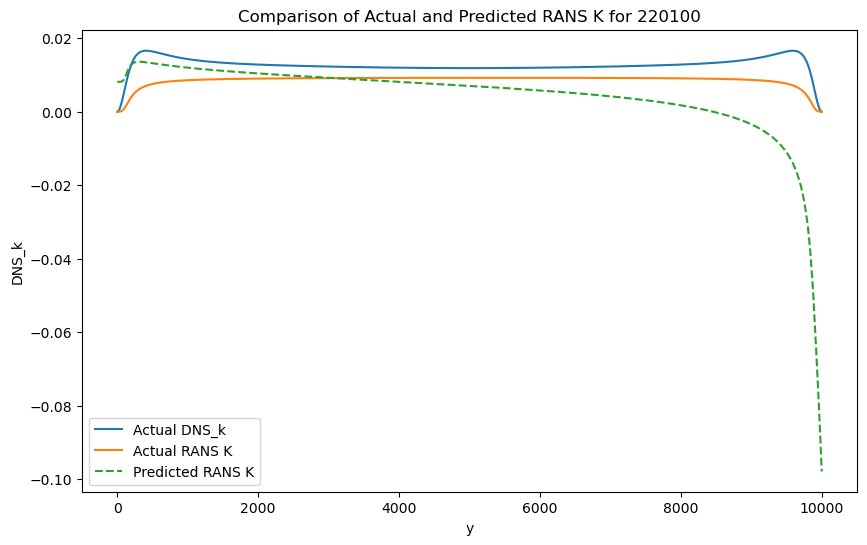

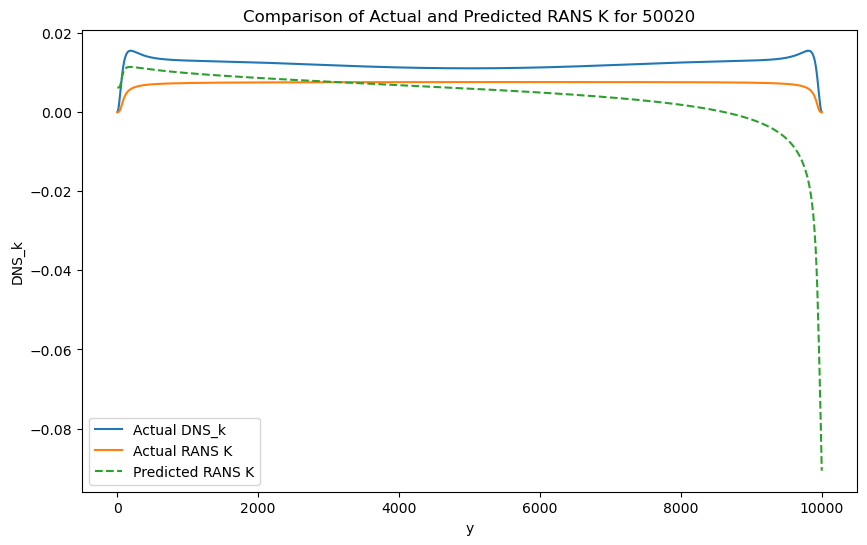

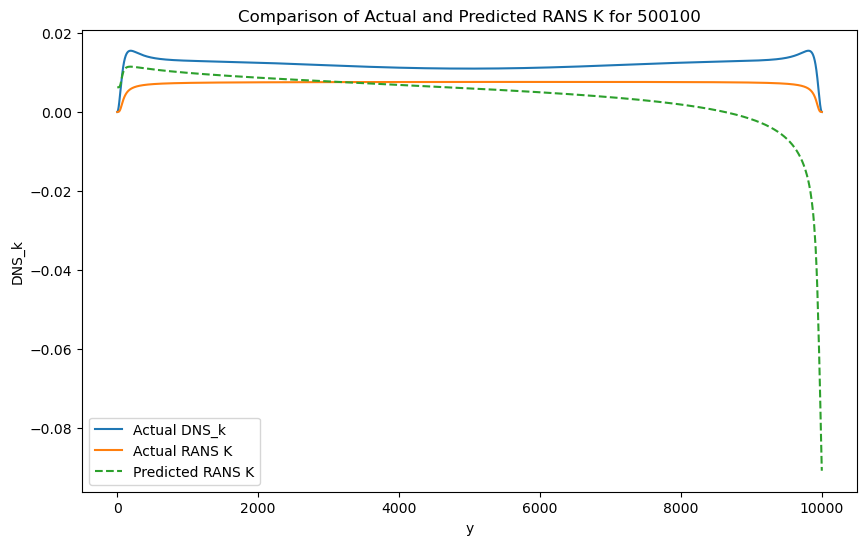

In [8]:
# Loop through all DNS data files to test the model
for couette, filename in couette_int_augmented_datafilenames.items():
    # Load the current DNS setup's data
    int_data = pd.read_csv(filename)
    params = couette_params_df[couette_params_df['couette'] == couette].iloc[0]
    
    # Append simulation parameters to the data for consistent feature representation
    for param in ['Re_tau', 'nu', 'u_tau']:
        int_data[param] = params[param]

    t = int_data['y'].values
    # Prepare features for prediction: U, its derivatives, and simulation parameters
    U = int_data['xvel_x'].values
    dU_dy = differentiation_method(U.reshape(-1, 1), t)
    d2U_dy2 = differentiation_method(dU_dy.flatten(), t).reshape(-1, 1)
    #d3U_dy3 = differentiation_method(d2U_dy2.flatten(), t).reshape(-1, 1)
    W = int_data['zvel_x'].values
    dW_dy = differentiation_method(W.reshape(-1, 1), t)
    d2W_dy2 = differentiation_method(dW_dy.flatten(), t).reshape(-1, 1)
    #d3W_dy3 = differentiation_method(d2W_dy2.flatten(), t).reshape(-1, 1)

    features = np.hstack((int_data[['xvel_x']].values, # U.reshape(-1, 1), 
                          dU_dy, 
                          #d2U_dy2, 
                          int_data[['zvel_x']].values, # W.reshape(-1, 1), 
                          #dW_dy, 
                          #d2W_dy2, 
                          int_data[['Re_tau', 'nu', 'u_tau']].values))
    
    # Actual values
    X_dot_actual_DNS = int_data[[
        #'u\'u\'', 'v\'v\'', 'w\'w\'', 'u\'v\'', 
        'DNS_k']].values
    
    # Actual values
    X_dot_actual_RANS = int_data[[
        #'u\'u\'', 'v\'v\'', 'w\'w\'', 'u\'v\'', 
        'RANS_k']].values
    # Predict derivatives using the model
    X_dot_predicted = model.predict(features)
    
    # Plot actual vs. predicted derivatives
    variable_names = [
        #'u\'u\'', 'v\'v\'', 'w\'w\'', 'u\'v\'', 
        'DNS_k']
    for i, var_name in enumerate(variable_names):
        plt.figure(figsize=(10, 6))
        plt.plot(X_dot_actual_DNS[:, i], label=f'Actual {var_name}')
        plt.plot(X_dot_actual_RANS[:, i], label=f'Actual RANS K')
        plt.plot(X_dot_predicted[:, i], label=f'Predicted RANS K', linestyle='--')
        plt.title(f'Comparison of Actual and Predicted RANS K for {couette}')
        plt.xlabel('y')
        plt.ylabel(var_name)
        plt.legend()
        plt.show()

**Predicted Couette Rans K (using bilateral reference)**

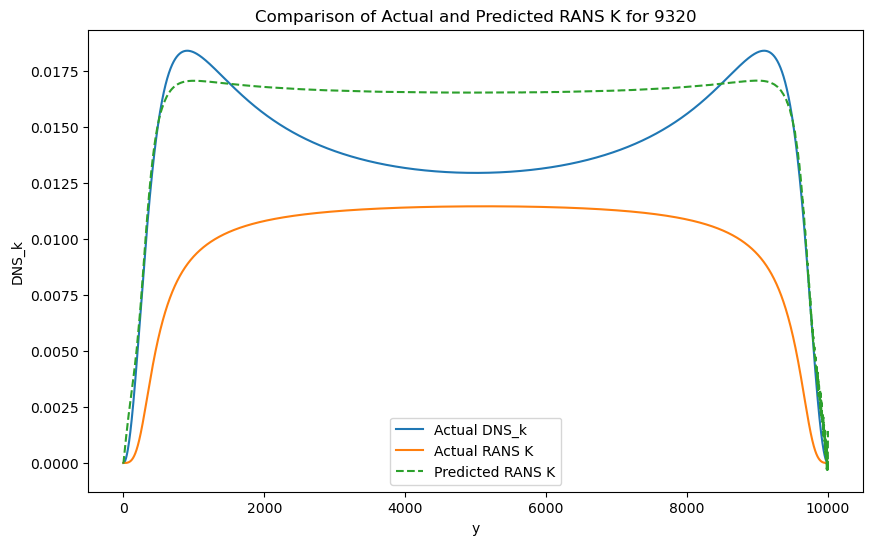

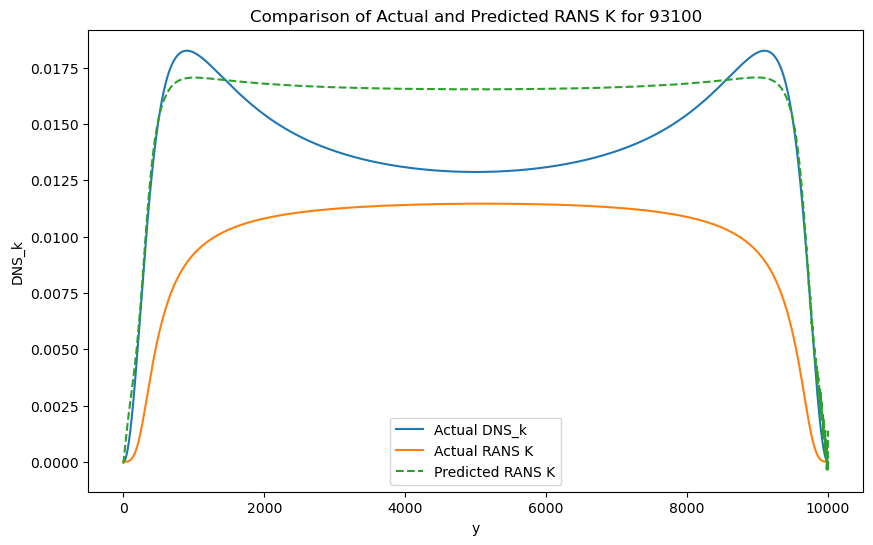

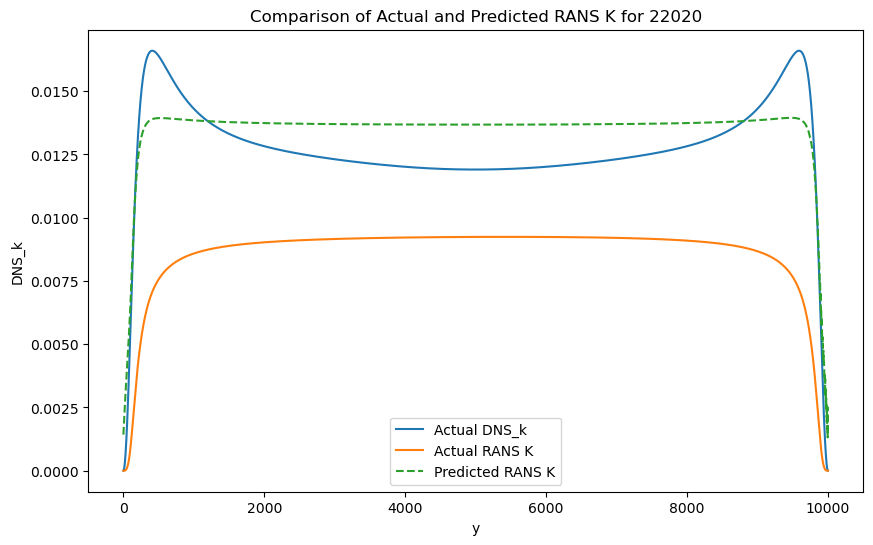

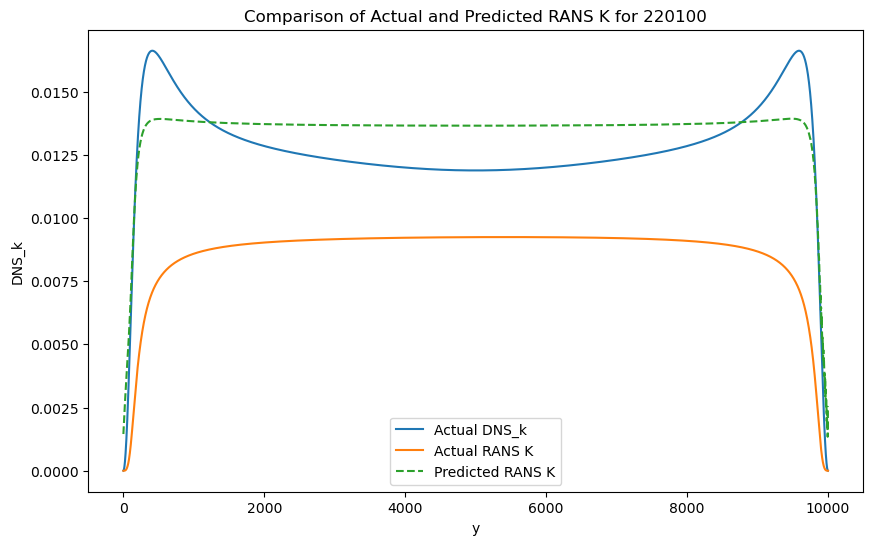

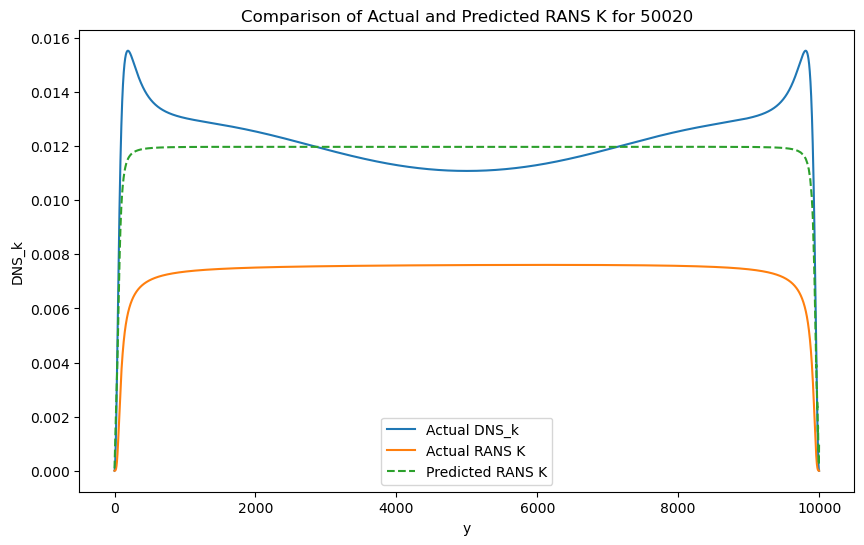

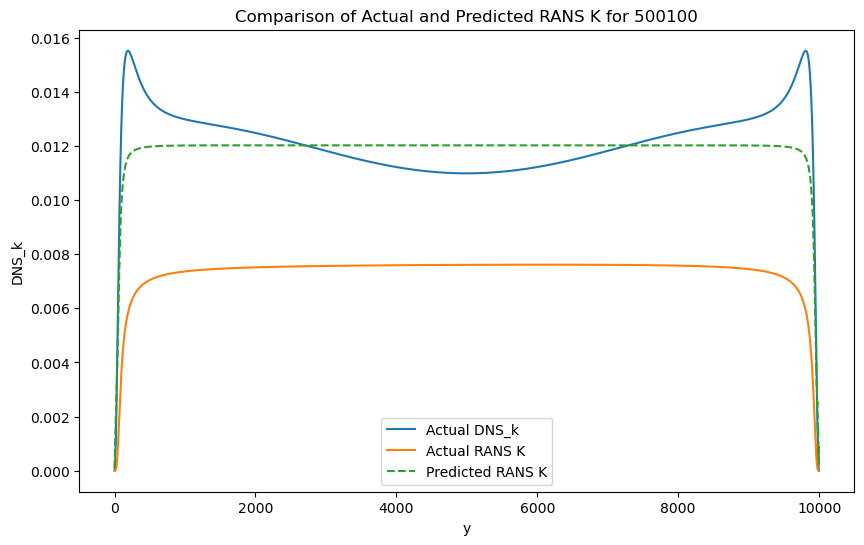

In [9]:
# Loop through all DNS data files to test the model
for couette, filename in couette_int_augmented_datafilenames.items():
    # Load the current DNS setup's data
    int_data = pd.read_csv(filename)
    params = couette_params_df[couette_params_df['couette'] == couette].iloc[0]
    
    # Append simulation parameters to the data for consistent feature representation
    for param in ['Re_tau', 'nu', 'u_tau']:
        int_data[param] = params[param]

    t = int_data['y'].values
    
    # Prepare features for prediction: U-1, its derivatives, and simulation parameters
    U = int_data['xvel_x'].values
    dU_dy = differentiation_method(U.reshape(-1, 1), t)
    d2U_dy2 = differentiation_method(dU_dy.flatten(), t).reshape(-1, 1)
    #d3U_dy3 = differentiation_method(d2U_dy2.flatten(), t).reshape(-1, 1)
    W = int_data['zvel_x'].values
    dW_dy = differentiation_method(W.reshape(-1, 1), t)
    d2W_dy2 = differentiation_method(dW_dy.flatten(), t).reshape(-1, 1)
    #d3W_dy3 = differentiation_method(d2W_dy2.flatten(), t).reshape(-1, 1)

    # Subtract 1 from U 
    int_data['xvel_x'] = int_data['xvel_x'] - 1

    features = np.hstack((int_data[['xvel_x']].values, # U.reshape(-1, 1), 
                          dU_dy, 
                          #d2U_dy2, 
                          int_data[['zvel_x']].values, # W.reshape(-1, 1), 
                          #dW_dy, 
                          #d2W_dy2, 
                          int_data[['Re_tau', 'nu', 'u_tau']].values))
    
    # Actual values
    X_dot_actual_DNS = int_data[['DNS_k']].values
    
    # Actual values
    X_dot_actual_RANS = int_data[['RANS_k']].values
    
    # Predict derivatives using the model
    X_dot_predicted = model.predict(features)
    
    # Plot actual vs. predicted derivatives
    variable_names = ['DNS_k']
    for i, var_name in enumerate(variable_names):
        plt.figure(figsize=(10, 6))
        plt.plot(X_dot_actual_DNS[:, i], label=f'Actual {var_name}')
        plt.plot(X_dot_actual_RANS[:, i], label=f'Actual RANS K')
        plt.plot(X_dot_predicted[:, i], label=f'Predicted RANS K', linestyle='--')
        plt.title(f'Comparison of Actual and Predicted RANS K for {couette}')
        plt.xlabel('y')
        plt.ylabel(var_name)
        plt.legend()
        plt.show()

# K as a function of velocities and velocity gradients (derivated by y/delta) using INTERPOLATED data (trained on RANS features)  
This section finds an equation using RANS values as features and DNS K values as a target.  
This will gives us great results that resemble the DNS K plots, but the equations loses physical meaning.  
This is not a good solution because if our RANS features are off or do not match the DNS features, the equation will not be generalizable.  
**This section has been deleted**

# Applying boussinesq hypothesis using DNS found k equation to RANS values.

The boussineq equation is 
\begin{equation}
-\overline{v'_i v'_j} = \nu_t \left( \frac{\partial \overline{v}_i}{\partial x_j} + \frac{\partial \overline{v}_j}{\partial x_i} \right) - \frac{2}{3} k \delta_{ij}
\end{equation}  
with *k = 0.170 Re_tau nu + 1416.174 dU/dy nu^2 + 19470943.105 W nu^2 + -893.130 dU/dy^2 nu^2 + 1.594 Re_tau^2 nu^2 + -0.153 U^4 u_tau + 10.366 U^2 u_tau^3 + -10.347 dU/dy^2 nu u_tau^2*

We will apply this equation to find :  
  
u'u' = - t_visc * (dxdx + dxdx) + (2/3) * k  
v'v' = - t_visc * (dydy + dydy) + (2/3) * k  
w'w' = - t_visc * (dzdz + dzdz) + (2/3) * k  
u'v' = - t_visc * (dxdy + dydx)  
  
With k = 0.170 * Re_tau nu + 1416.174 * dxdy nu^2 + 19470943.105 zvel_x * nu^2 - 893.130 * dxdy^2 * nu^2 + 1.594 * Re_tau^2 * nu^2 + -0.153 * xvel_x^4 * u_tau + 10.366 * xvel_x^2 * u_tau^3 - 10.347 * dxdy^2 * nu * u_tau^2

**We will use the equation with the RANS values and compare against actual DNS covariances.**



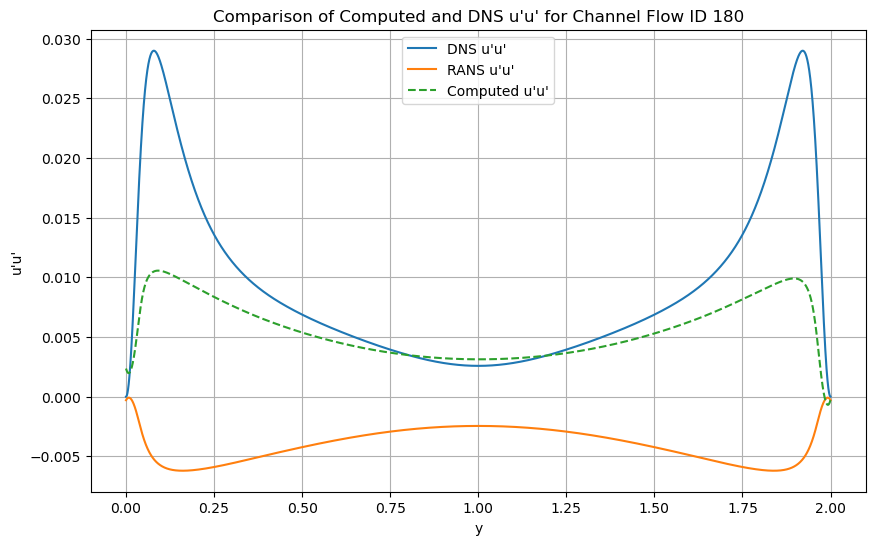

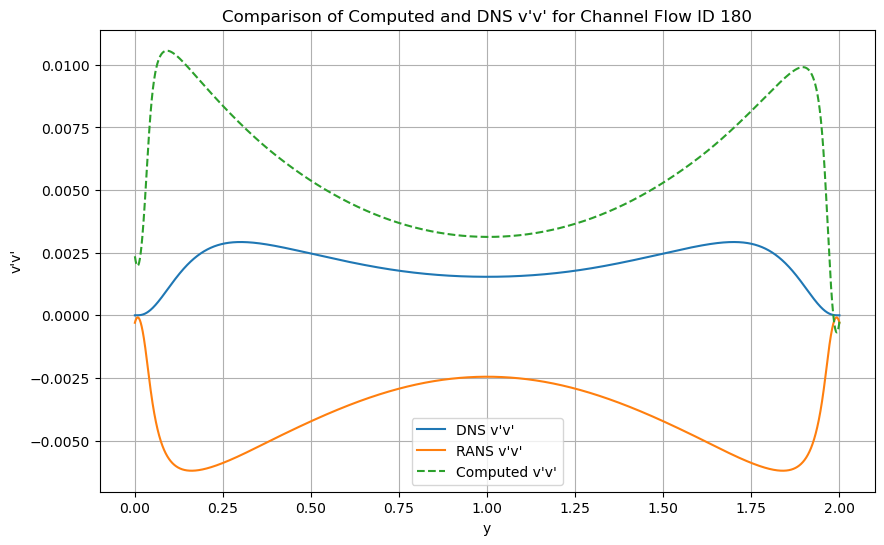

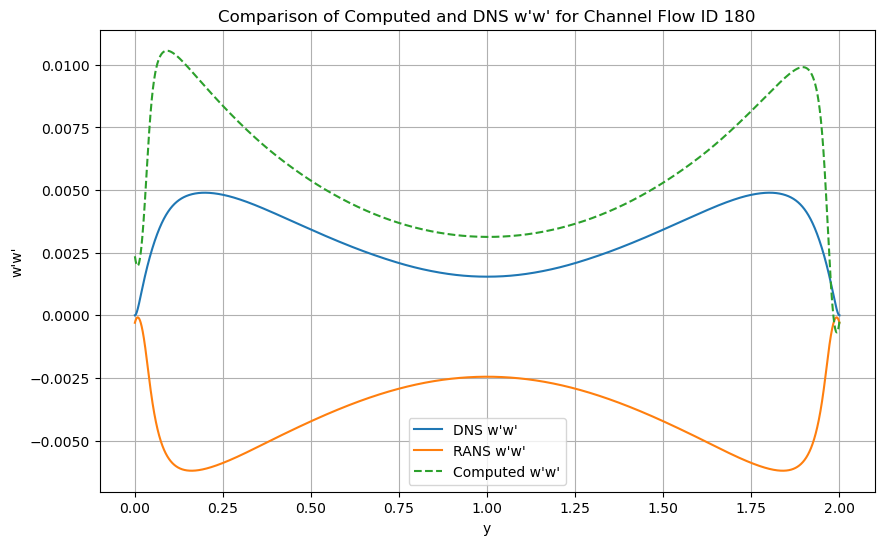

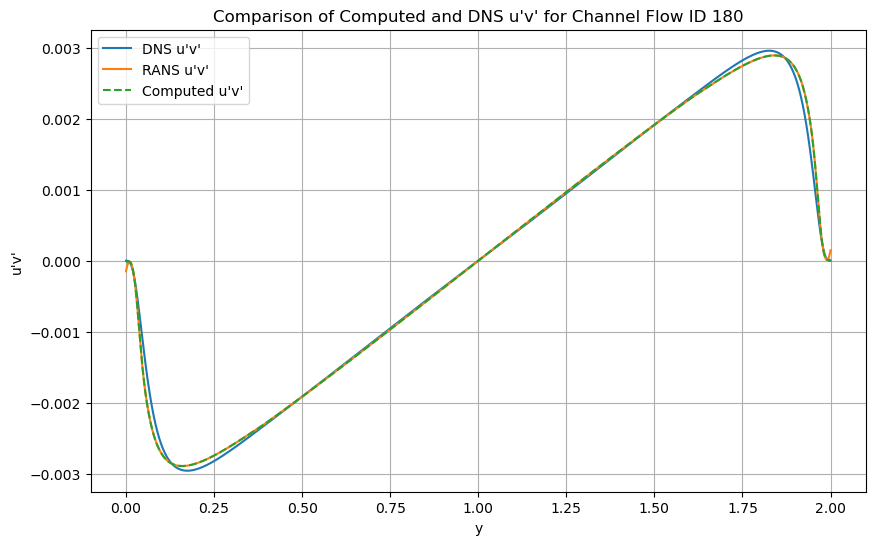

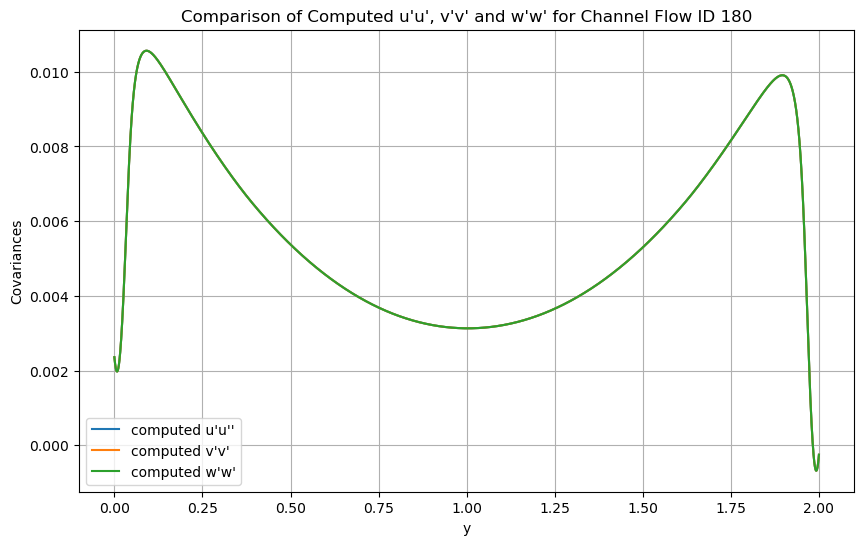

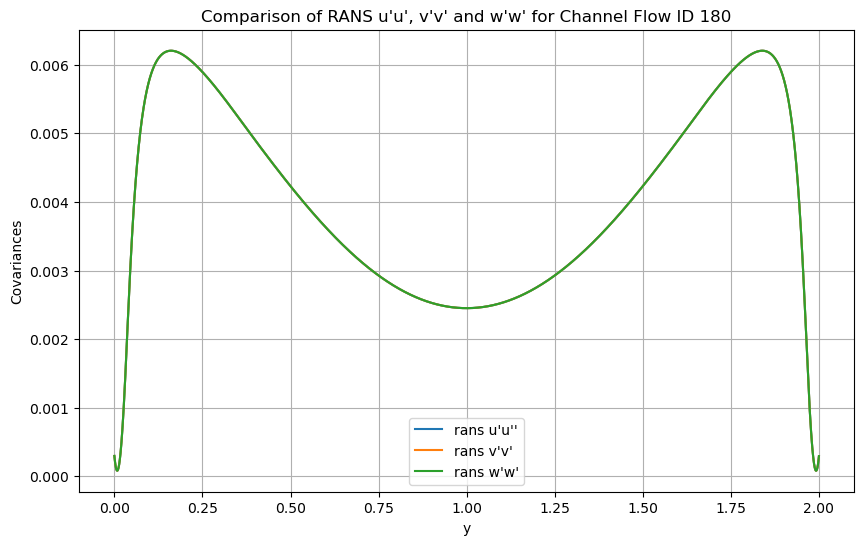

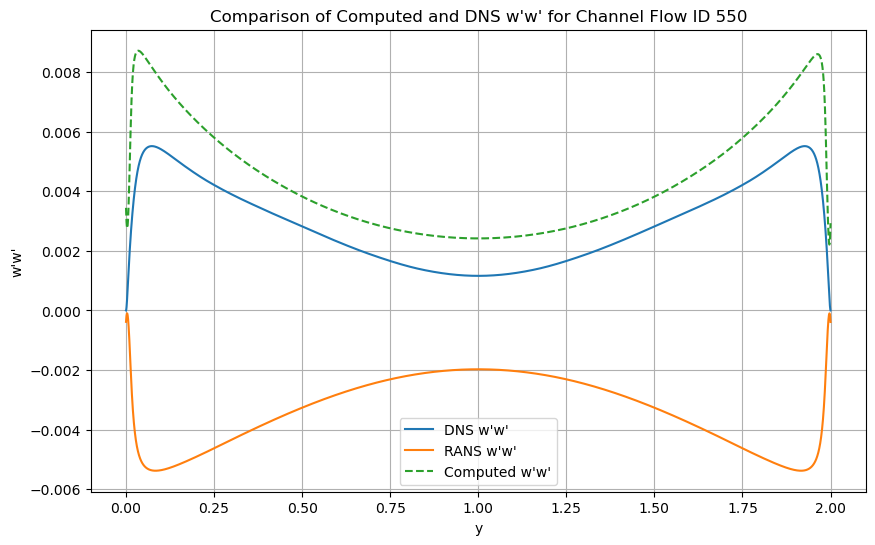

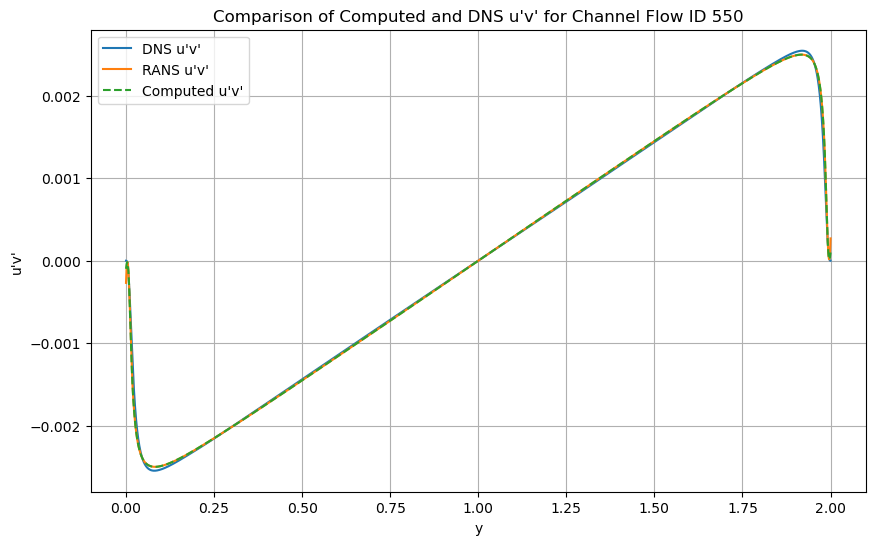

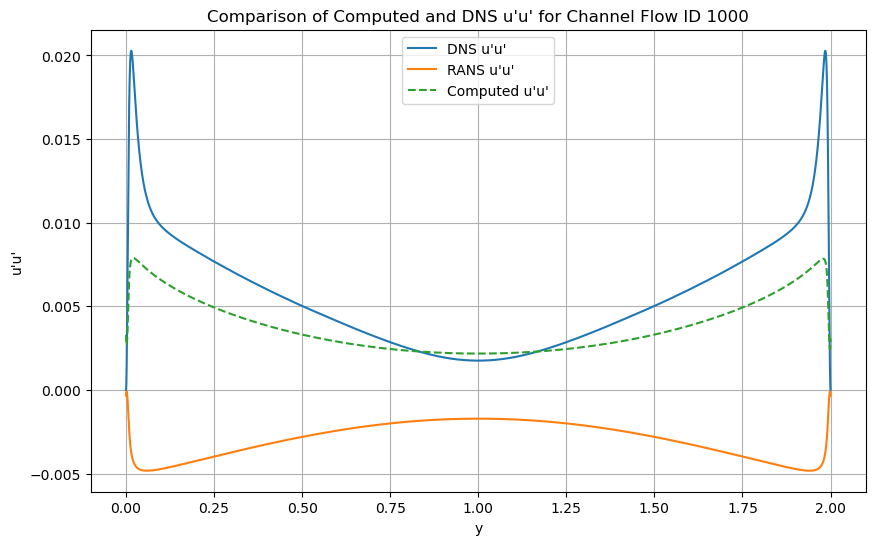

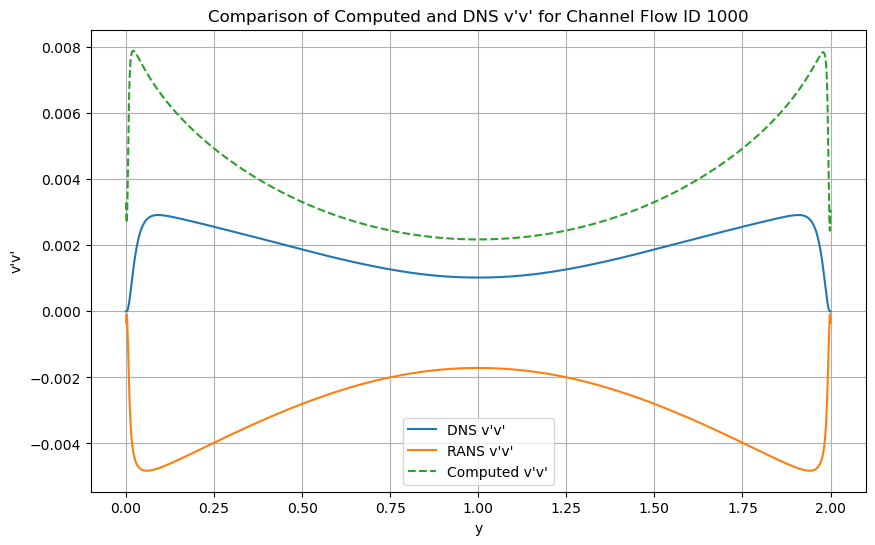

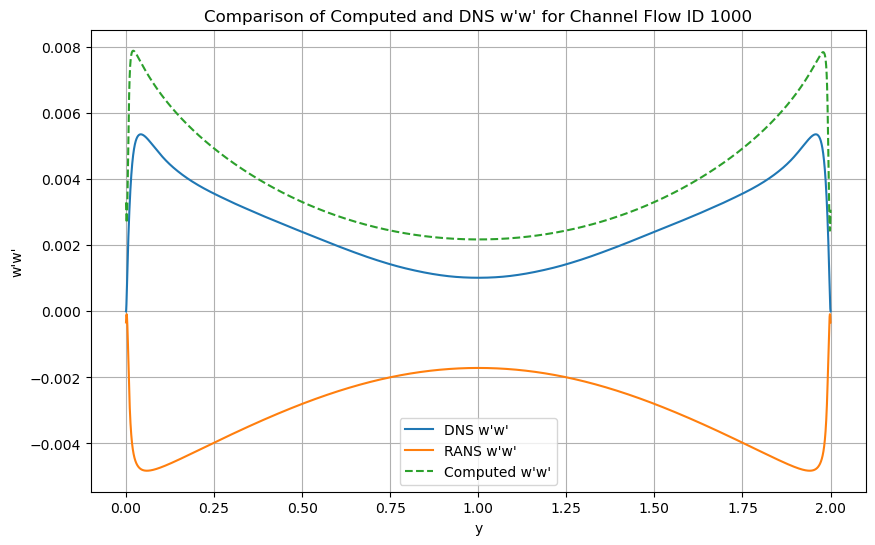

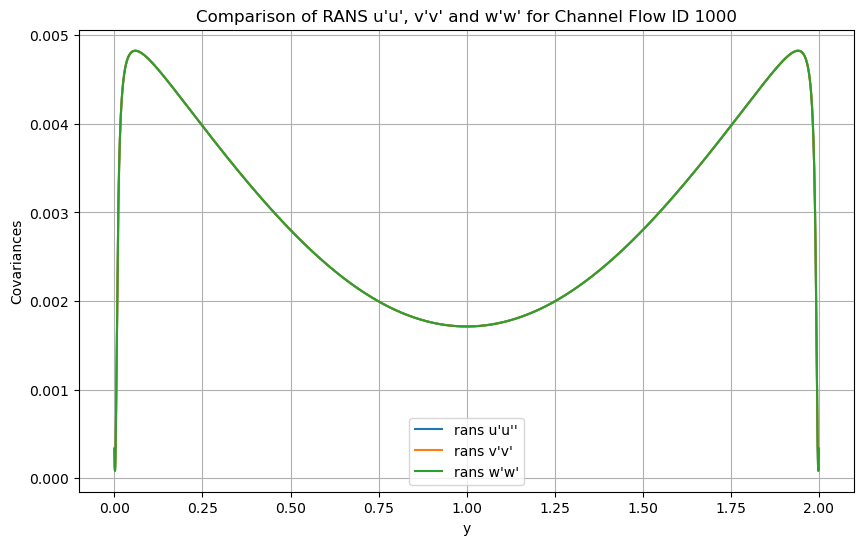

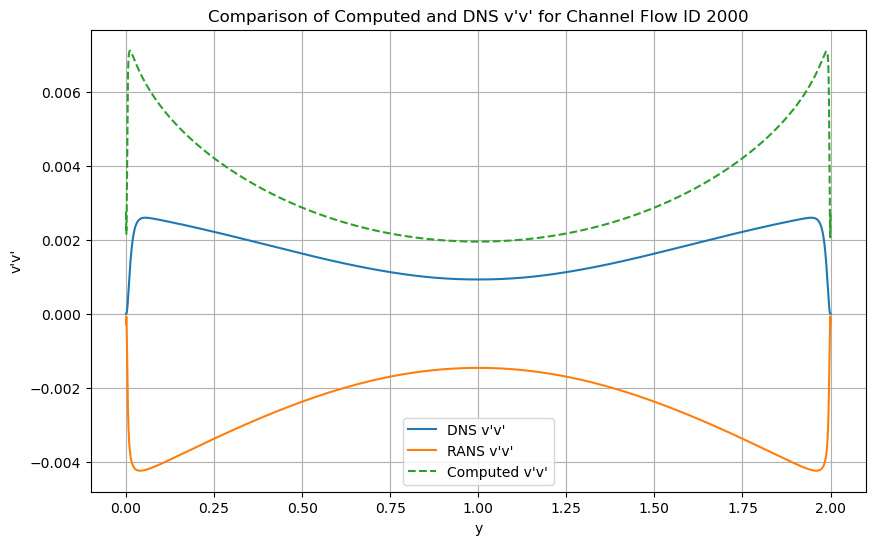

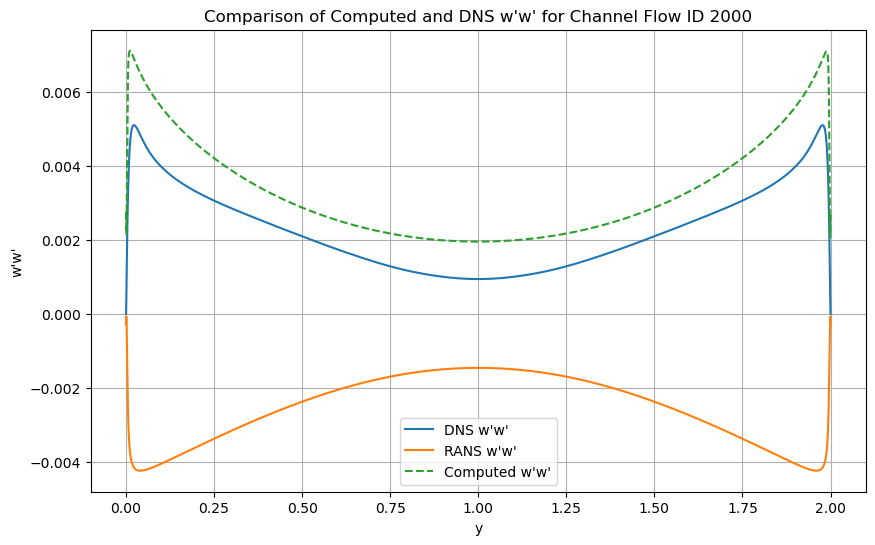

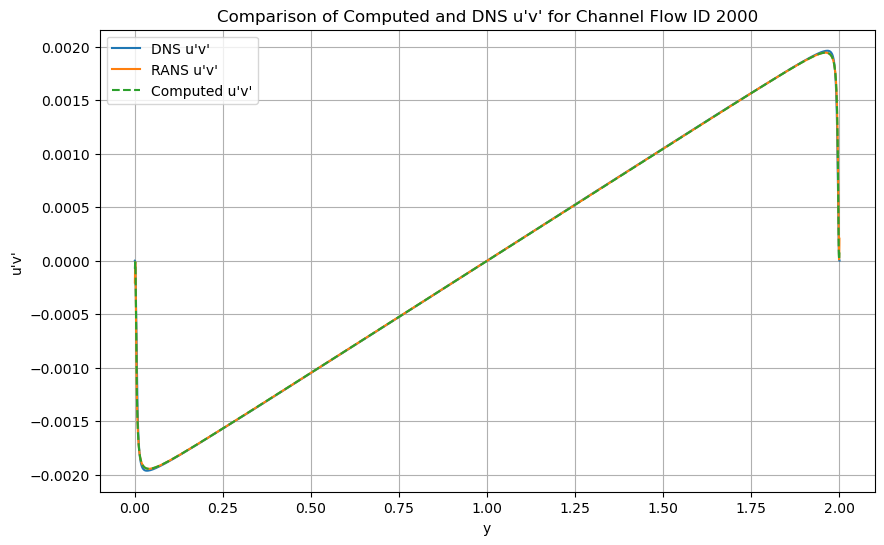

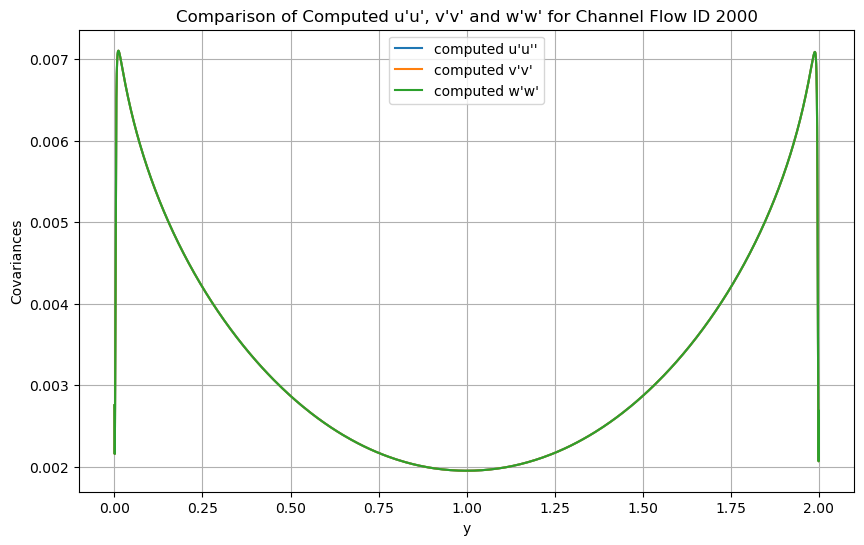

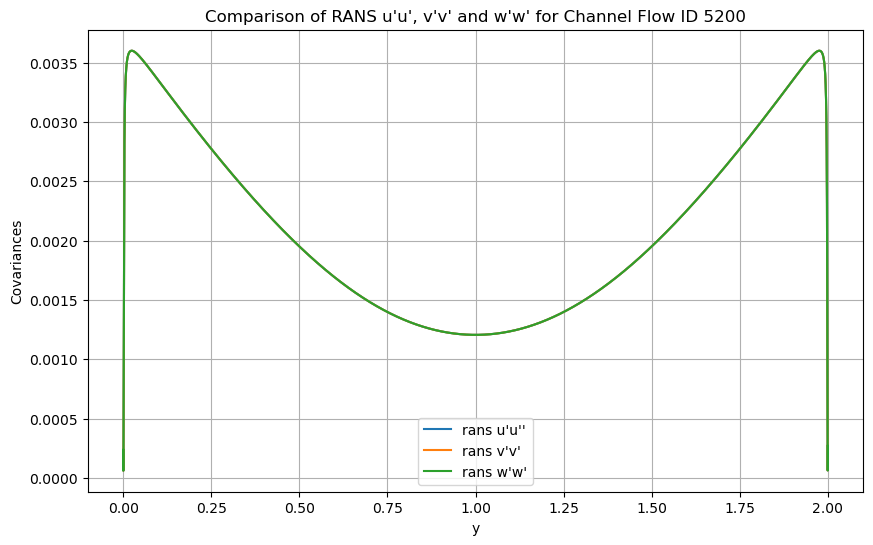

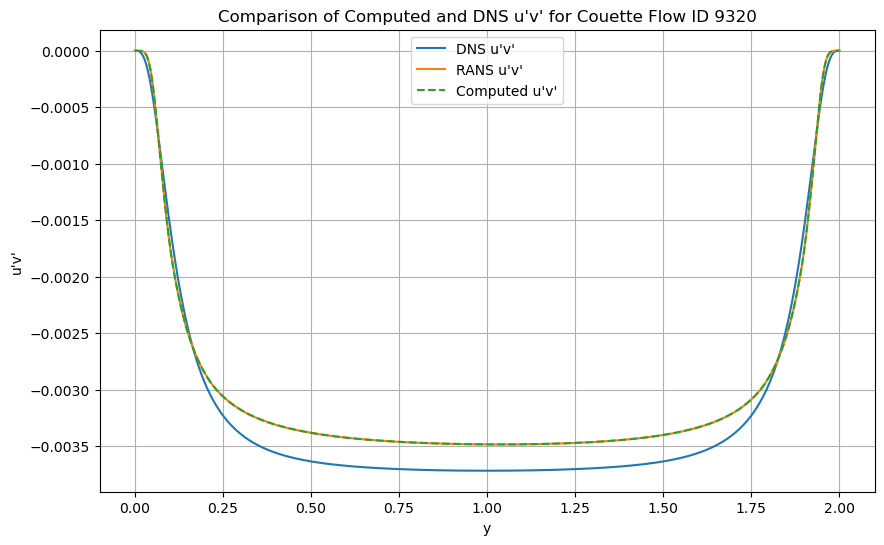

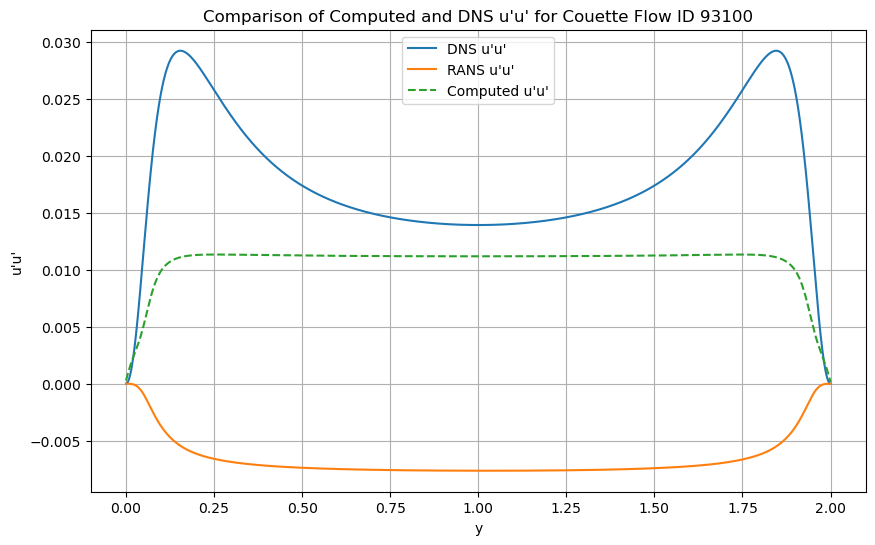

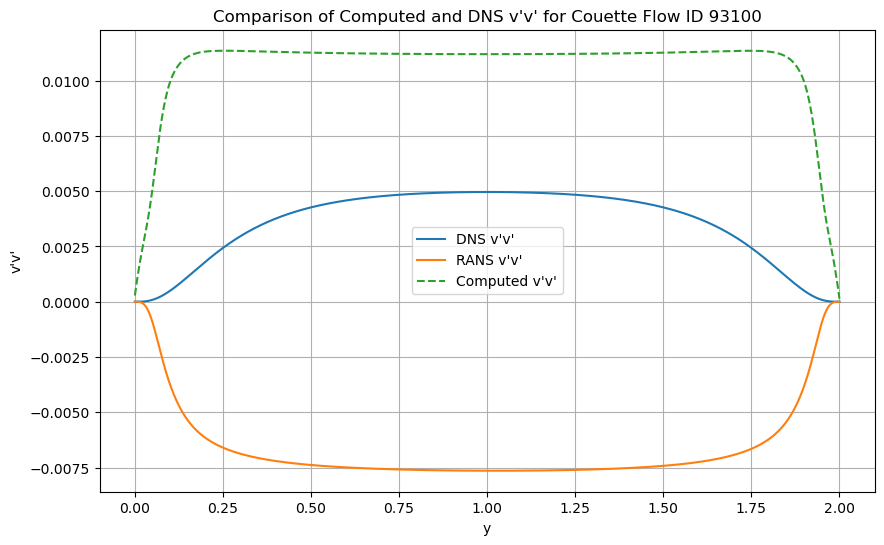

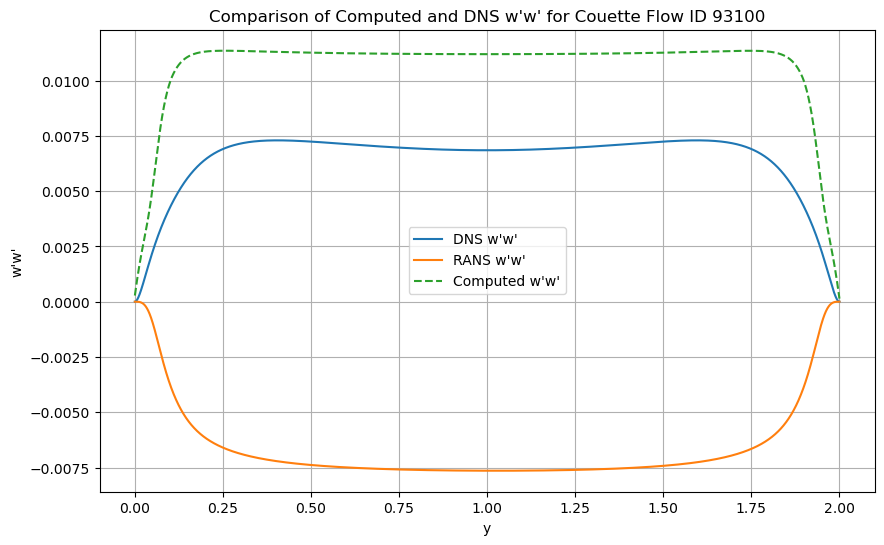

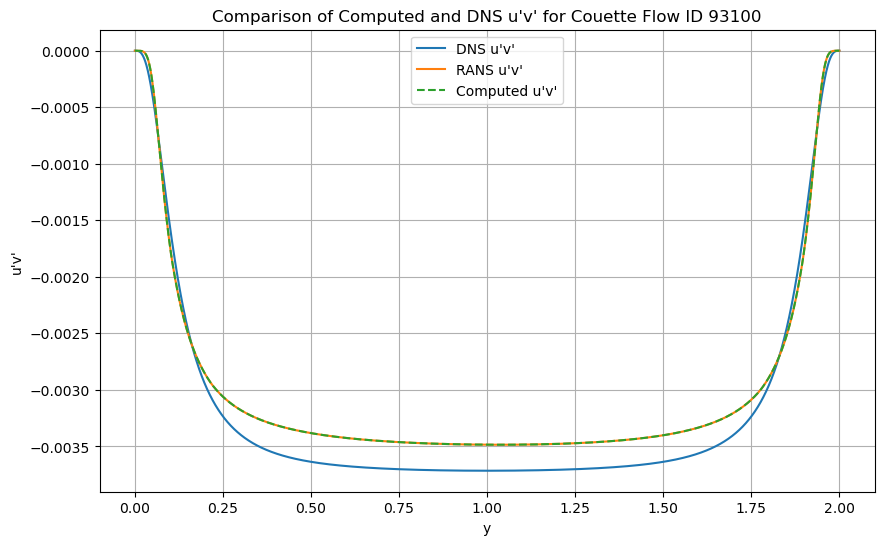

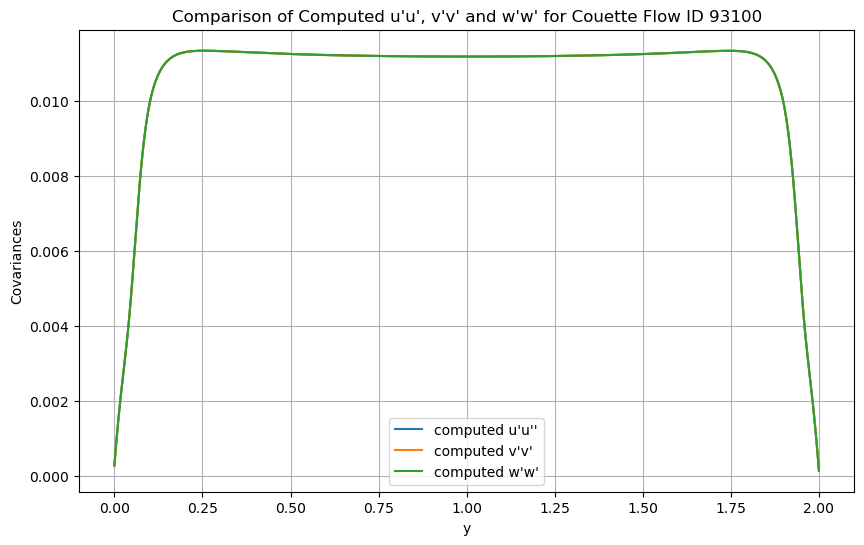

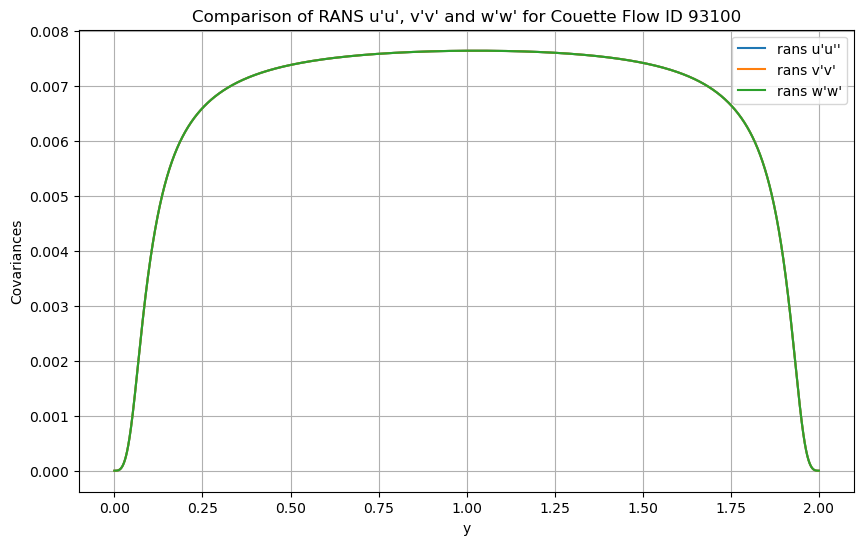

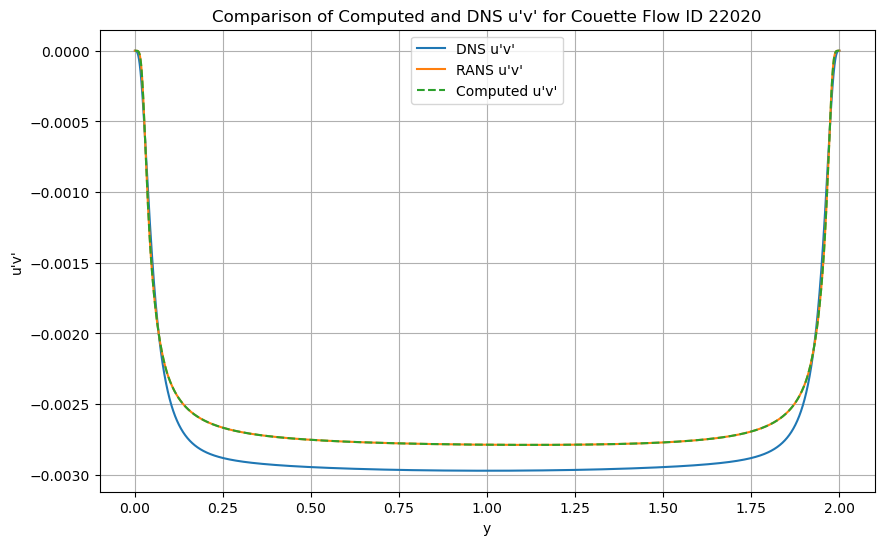

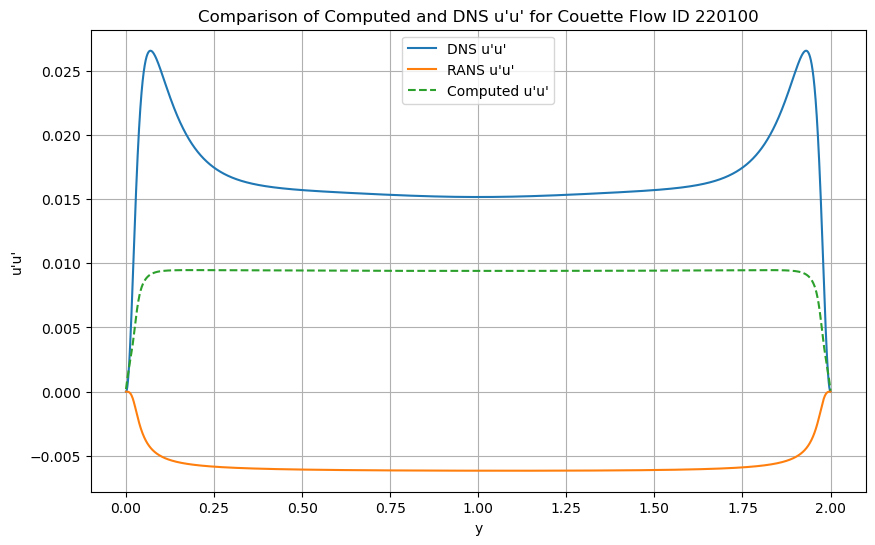

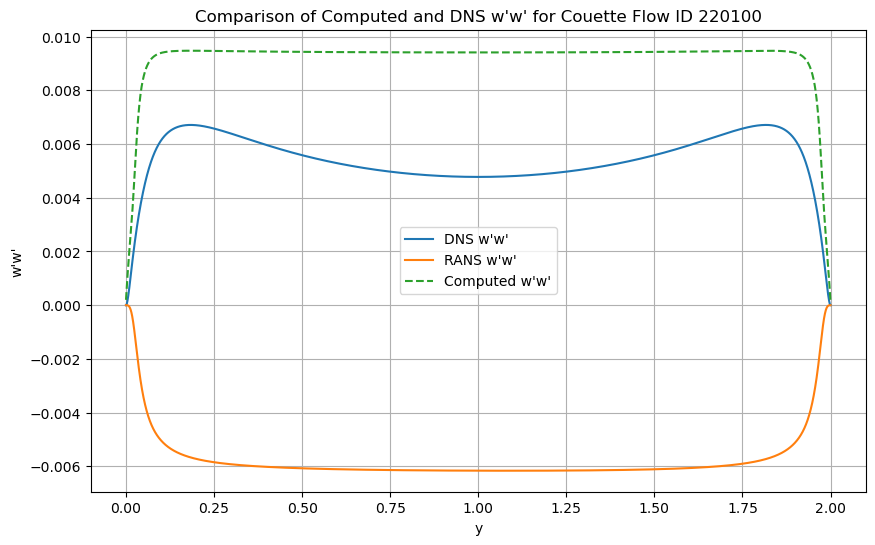

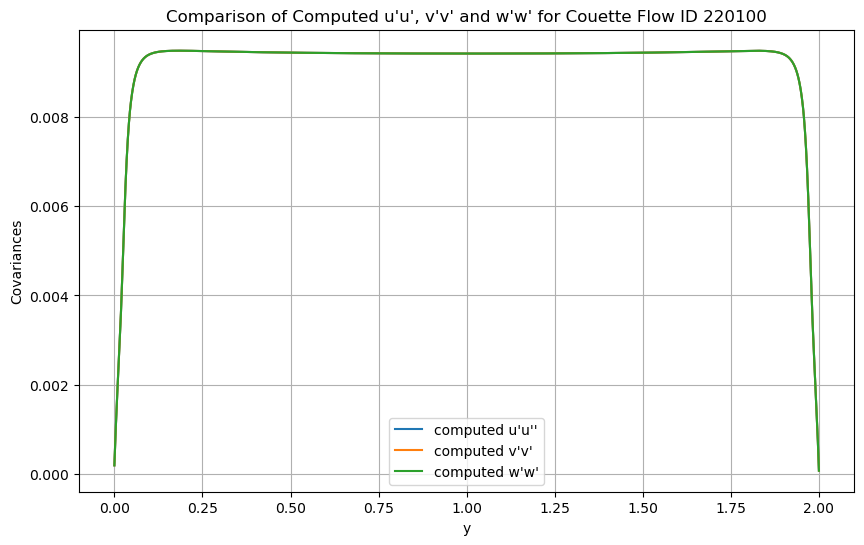

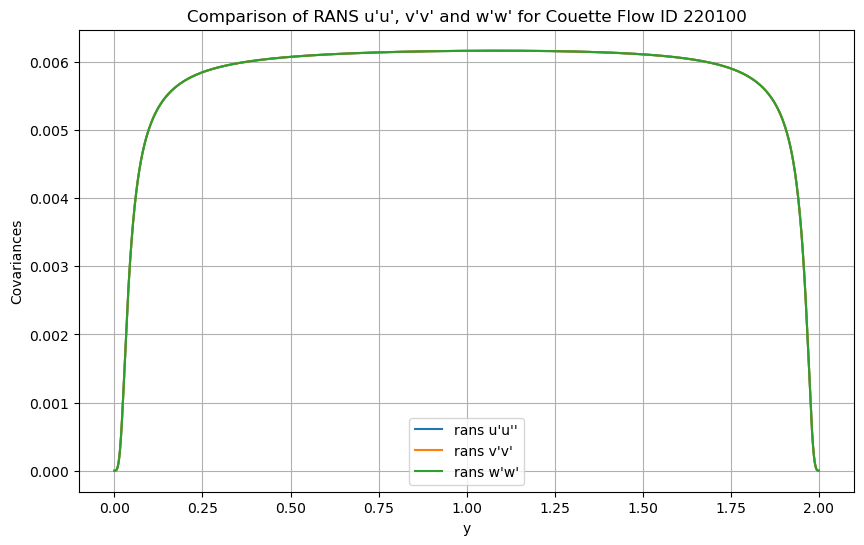

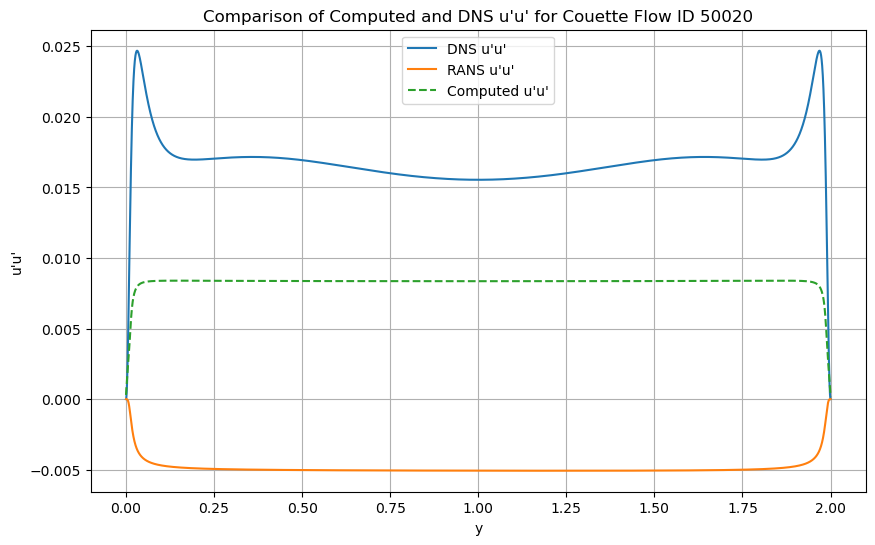

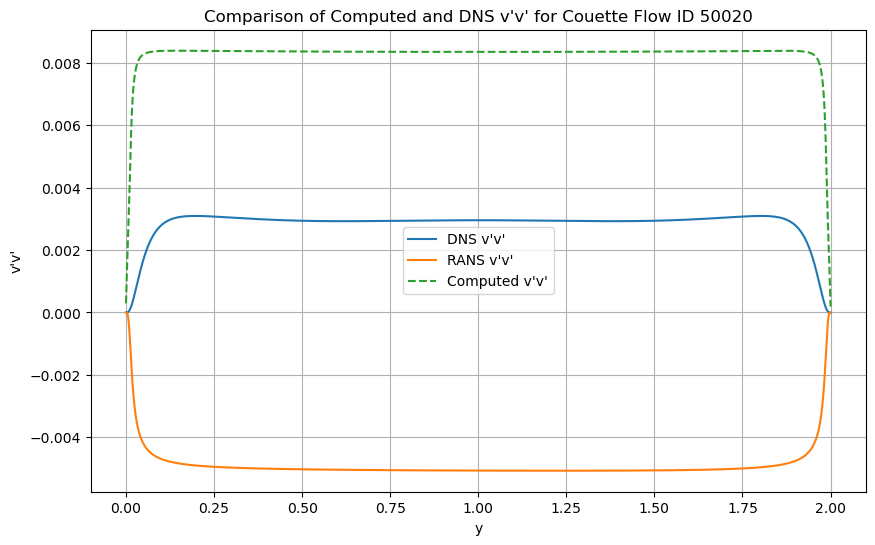

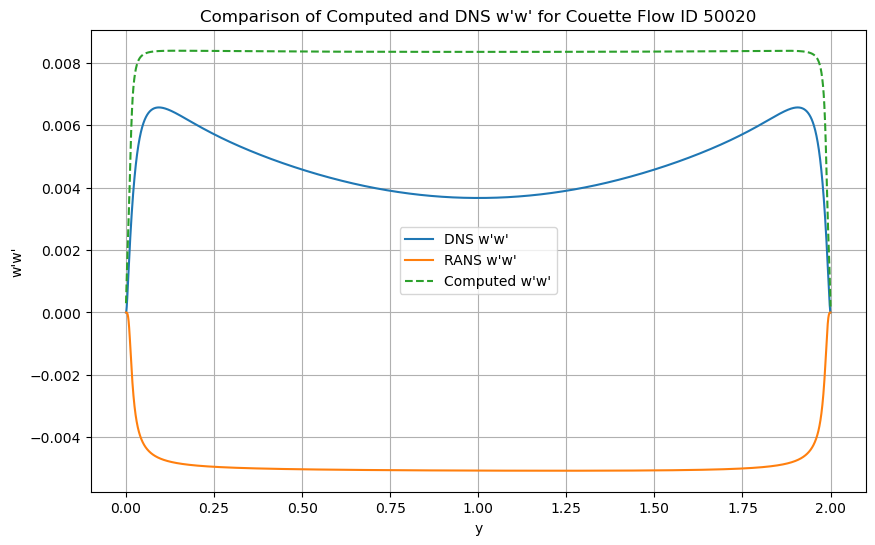

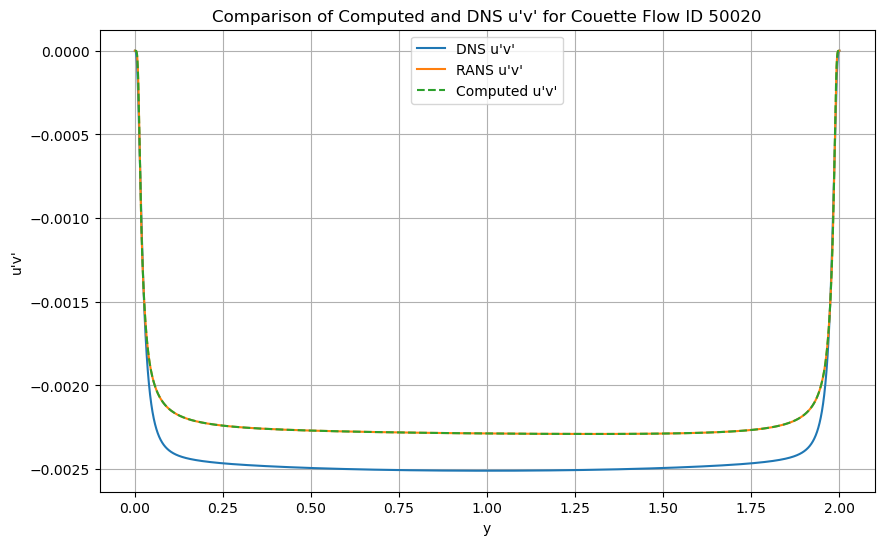

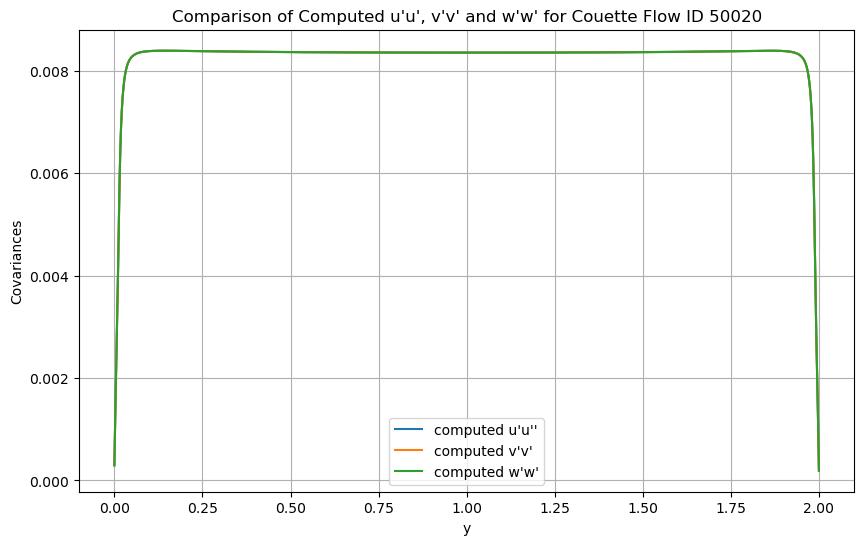

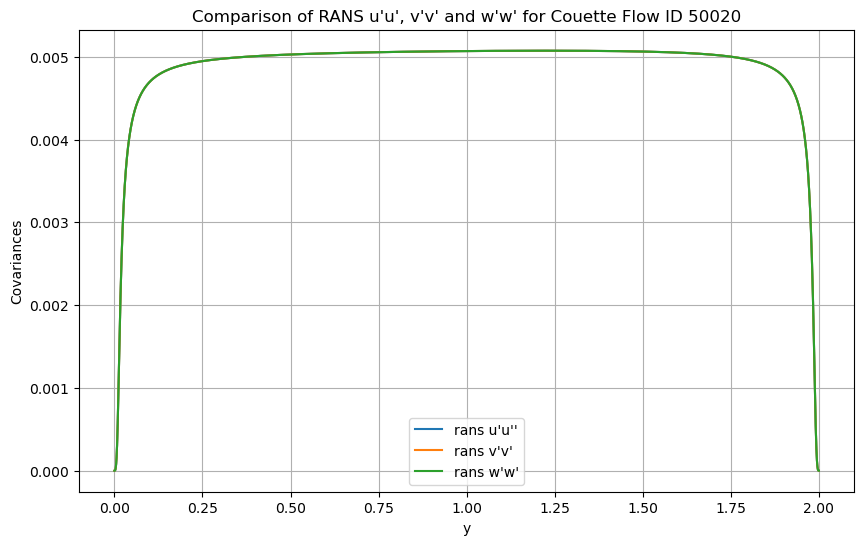

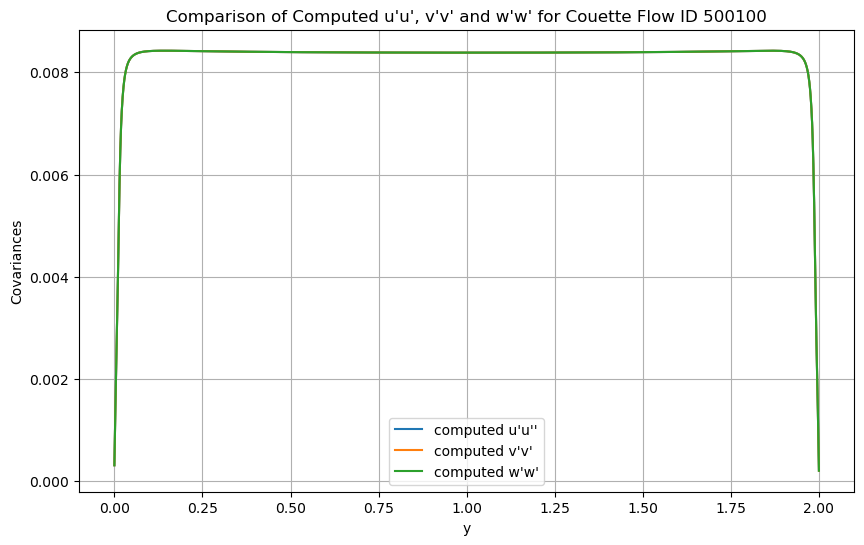

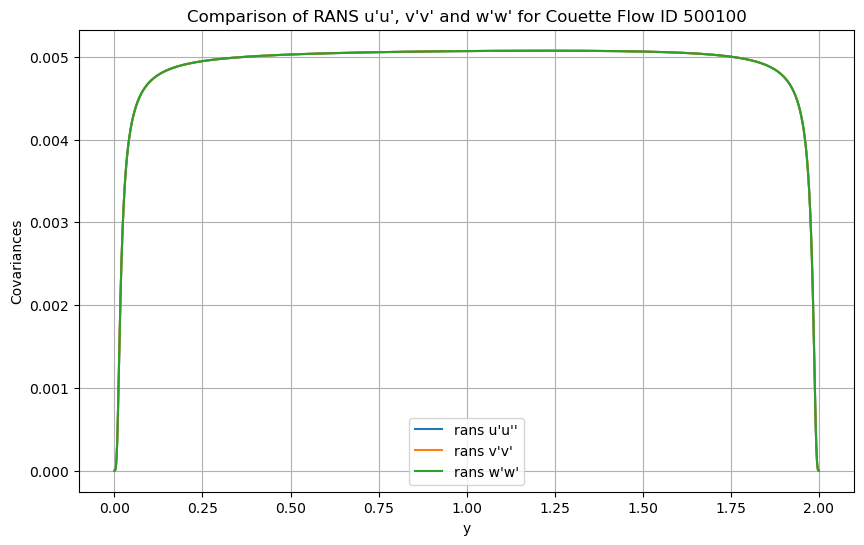

In [10]:
# With RANS values

datasets = {
    "Channel": [180, 550, 1000, 2000, 5200],
    "Couette": [9320, 93100, 22020, 220100, 50020, 500100]
}

covariances = ['u\'u\'', 'v\'v\'', 'w\'w\'', 'u\'v\'']
computed_covariances = ['computed_u\'u\'', 'computed_v\'v\'', 'computed_w\'w\'', 'computed_u\'v\'']

for flow_type, ids in datasets.items():
    for id in ids:
        # Determine the correct filenames and parameters based on flow type
        filename = (channel_int_augmented_datafilenames if flow_type == "Channel" else couette_int_augmented_datafilenames)[id]
        filename_rans = (channel_int_augmented_datafilenames if flow_type == "Channel" else couette_int_augmented_datafilenames)[id]
        params_df_selected = params_df if flow_type == "Channel" else couette_params_df
        params = params_df_selected[params_df_selected[flow_type.lower()] == id].iloc[0]
        
        # Load data
        int_data = pd.read_csv(filename)
        rans_data = pd.read_csv(filename_rans)

        # Append simulation parameters as new columns
        for param in ['Re_tau', 'nu', 'u_tau']:
            int_data[param] = params[param]

        # Subtract -1 from 'U' for Couette files
        if flow_type == "Couette":
            int_data['xvel_x'] = int_data['xvel_x'] - 1

        # Compute k using the provided equation
        nu = int_data['nu'].values
        Re_tau = int_data['Re_tau'].values
        u_tau = int_data['u_tau'].values
        dxdy = int_data['dxdy'].values
        zvel_x = int_data['zvel_x'].values 
        xvel_x = int_data['xvel_x'].values

        # Compute k
        k = (0.170 * Re_tau * nu +
             1416.174 * dxdy * np.square(nu) +
             19470943.105 * zvel_x * np.square(nu) -
             893.130 * np.square(dxdy) * np.square(nu) +
             1.594 * np.square(Re_tau) * np.square(nu) +
             -0.153 * np.power(xvel_x, 4) * u_tau +
             10.366 * np.square(xvel_x) * np.power(u_tau, 3) -
             10.347 * np.square(dxdy) * nu * np.square(u_tau))

        # Compute covariances
        int_data['computed_u\'u\''] = -int_data['t_visc'] * (2 * int_data['dxdx']) + (2/3) * k
        int_data['computed_v\'v\''] = -int_data['t_visc'] * (2 * int_data['dydy']) + (2/3) * k
        int_data['computed_w\'w\''] = -int_data['t_visc'] * (2 * int_data['dzdz']) + (2/3) * k 
        int_data['computed_u\'v\''] = -int_data['t_visc'] * (int_data['dxdy'] + int_data['dydx'])  
        
        # Plotting the comparison of computed and DNS u'u'
        plt.figure(figsize=(10, 6))
        plt.plot(int_data['y'], int_data["u'u'"], label="DNS u'u'")
        plt.plot(rans_data['y'], -rans_data["uu"], label="RANS u'u'")
        plt.plot(int_data['y'], int_data["computed_u'u'"], label="Computed u'u'", linestyle='--')
        plt.xlabel('y')
        plt.ylabel("u'u'")
        plt.title(f"Comparison of Computed and DNS u'u' for {flow_type} Flow ID {id}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plotting the comparison of computed and DNS v'v'
        plt.figure(figsize=(10, 6))
        plt.plot(int_data['y'], int_data["v'v'"], label="DNS v'v'")
        plt.plot(rans_data['y'], -rans_data["vv"], label="RANS v'v'")
        plt.plot(int_data['y'], int_data["computed_v'v'"], label="Computed v'v'", linestyle='--')
        plt.xlabel('y')
        plt.ylabel("v'v'")
        plt.title(f"Comparison of Computed and DNS v'v' for {flow_type} Flow ID {id}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plotting the comparison of computed and DNS w'w'
        plt.figure(figsize=(10, 6))
        plt.plot(int_data['y'], int_data["w'w'"], label="DNS w'w'")
        plt.plot(rans_data['y'], -rans_data["ww"], label="RANS w'w'")
        plt.plot(int_data['y'], int_data["computed_w'w'"], label="Computed w'w'", linestyle='--')
        plt.xlabel('y')
        plt.ylabel("w'w'")
        plt.title(f"Comparison of Computed and DNS w'w' for {flow_type} Flow ID {id}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plotting the comparison of computed and DNS u'v'
        plt.figure(figsize=(10, 6))
        plt.plot(int_data['y'], int_data["u'v'"], label="DNS u'v'")
        plt.plot(rans_data['y'], rans_data["uv"], label="RANS u'v'")
        plt.plot(int_data['y'], int_data["computed_u'v'"], label="Computed u'v'", linestyle='--')
        plt.xlabel('y')
        plt.ylabel("u'v'")
        plt.title(f"Comparison of Computed and DNS u'v' for {flow_type} Flow ID {id}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plotting the comparison of computed u'u', v'v' and w'w'
        plt.figure(figsize=(10, 6))
        plt.plot(int_data['y'], int_data["computed_u'u'"], label="computed u'u''")
        plt.plot(int_data['y'], int_data["computed_v'v'"], label="computed v'v'")
        plt.plot(int_data['y'], int_data["computed_w'w'"], label="computed w'w'")
        plt.xlabel('y')
        plt.ylabel("Covariances")
        plt.title(f"Comparison of Computed u'u', v'v' and w'w' for {flow_type} Flow ID {id}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plotting the comparison of RANS u'u', v'v' and w'w'
        plt.figure(figsize=(10, 6))
        plt.plot(rans_data['y'], rans_data["uu"], label="rans u'u''")
        plt.plot(rans_data['y'], rans_data["vv"], label="rans v'v'")
        plt.plot(rans_data['y'], rans_data["ww"], label="rans w'w'")
        plt.xlabel('y')
        plt.ylabel("Covariances")
        plt.title(f"Comparison of RANS u'u', v'v' and w'w' for {flow_type} Flow ID {id}")
        plt.legend()
        plt.grid(True)
        plt.show()

# Analysis  
We observe that we end up with the same shortcomings as the already existing RANS results. That is to say that the velocity gradients are so insignificant next to k that the results for u'u', v'v', and w'w' are all equivalent for a given test setup. Only u'v' is different from u'u', v'v', and w'w' because k is not involved in its computation.